In [50]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed

#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [51]:
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_PU140_NTUPLE_1_version4.root'

In [52]:
#load the file
tree = uproot.open(filename+":myana/mytree")
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [53]:
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu']) 
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 

In [54]:
#dataset for mpp vs mll for pile-up and signal pairs.
import awkward as ak
import math as m
N = len(muons) # number of events
#define data array
data={}
for i in ['b','s']:
    for k in ['pt','eta','phi','m','t','vz']:
        data[i+'_mu1_'+k]=[]
        data[i+'_mu2_'+k]=[]
    for k in ['vz','xi']:
        data[i+'_pr1_'+k]=[]
        data[i+'_pr2_'+k]=[]
    for k in ['pt2','t','z']:
        data[i+'_pr_vtx_'+k]=[]
# add event kinematics
    data[i+'_mll']=[]
    data[i+'_yll']=[]
    data[i+'_mpp']=[]
    data[i+'_ypp']=[]
    data[i+'_evt_t0']=[]
#loop over all events for the signal
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=protons[i]
    pr1_idx=-1; pr2_idx=-1
    #pick up 2 signal protons
    pr1_idx=np.where(ak.to_numpy( (pr.genproton_ispu==0) & (pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0][0]
    pr2_idx=np.where(ak.to_numpy( (pr.genproton_ispu==0) & (pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0][0]
    #skip events if signal protons are missing
    if pr1_idx<0 or pr2_idx<0: continue
    #store muons
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['s_mu1_pt'].append(mu1.Pt())
    data['s_mu1_eta'].append(mu1.Eta())
    data['s_mu1_phi'].append(mu1.Phi())
    data['s_mu1_m'].append(mu1.M())
    data['s_mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['s_mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['s_mu2_pt'].append(mu2.Pt())
    data['s_mu2_eta'].append(mu2.Eta())
    data['s_mu2_phi'].append(mu2.Phi())
    data['s_mu2_m'].append(mu2.M())
    data['s_mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['s_mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['s_mll'].append((mu1+mu2).M())
    data['s_yll'].append((mu1+mu2).Eta())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['s_pr1_xi'].append(xi1)
    data['s_pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['s_pr2_xi'].append(xi2)
    data['s_pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    data['s_mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['s_ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=vertices[i]
    data['s_pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['s_pr_vtx_t'].append(vx.vtx4D_t[0])
    data['s_pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=event_info[i]
    data['s_evt_t0'].append(ev.genvtx_t0)
#loop over all events for the background
n = len(data['s_pr1_xi'])
for i in tqdm(range(n)): 
    #find index of two highest pT muons
    mu=muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        #if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=protons[i]
    pr1_idx=-1; pr2_idx=-1
    #pick 2 random pileup protons
    #get all indices of positive and negative protons:
    b_proton_pos_idx=np.where(ak.to_numpy((pr.genproton_ispu) & (pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0]
    b_proton_neg_idx=np.where(ak.to_numpy((pr.genproton_ispu) & (pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0]
    #create list of all possible pair combinations betwen list 1 and list 2:
    b_proton_pairs_idx=np.array(np.meshgrid(b_proton_pos_idx,b_proton_neg_idx)).T.reshape(-1,2)
    #pick up a random pair:
    b_pr1_idx, b_pr2_idx  = b_proton_pairs_idx[np.random.randint(b_proton_pairs_idx.shape[0], size=1)][0]
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['b_mu1_pt'].append(mu1.Pt())
    data['b_mu1_eta'].append(mu1.Eta())
    data['b_mu1_phi'].append(mu1.Phi())
    data['b_mu1_m'].append(mu1.M())
    data['b_mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['b_mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['b_mu2_pt'].append(mu2.Pt())
    data['b_mu2_eta'].append(mu2.Eta())
    data['b_mu2_phi'].append(mu2.Phi())
    data['b_mu2_m'].append(mu2.M())
    data['b_mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['b_mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['b_mll'].append((mu1+mu2).M())
    data['b_yll'].append((mu1+mu2).Eta())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['b_pr1_xi'].append(xi1)
    data['b_pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['b_pr2_xi'].append(xi2)
    data['b_pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    #otherwise nan in sqrt
    #if ((xi1*xi2)<1e-11): continue
    data['b_mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['b_ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=vertices[i]
    data['b_pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['b_pr_vtx_t'].append(vx.vtx4D_t[0])
    data['b_pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=event_info[i]
    data['b_evt_t0'].append(ev.genvtx_t0)
print(len(data['s_mu1_t']))
print(len(data['b_mpp']))

100%|██████████| 64/64 [00:00<00:00, 89.36it/s]


64
64


In [55]:
analysis = pd.DataFrame(data=data)


64


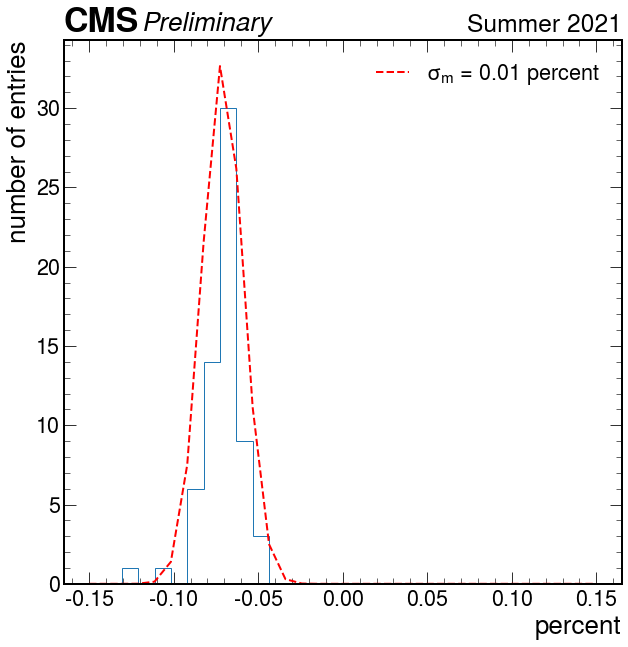

In [56]:
#You can plot mpp/mll-1 distribution, fit a gaussian and define a cut to be within the 2 sigma: |mpp-mll| < 2*sigma*mll
#print(analysis['s_mpp'].values)
#print(analysis['s_mll'].values)
data = (analysis['s_mpp'].values/analysis['s_mll'].values)-1
print(len(data))
bins = np.linspace(-0.15,0.15,32)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu, sigma_m) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu, sigma_m)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{m}$ = %2.2f percent'%sigma_m)
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent', ylabel='number of entries')

ax.legend()
#plt.savefig('Week4/fit_mass_ratio.png')

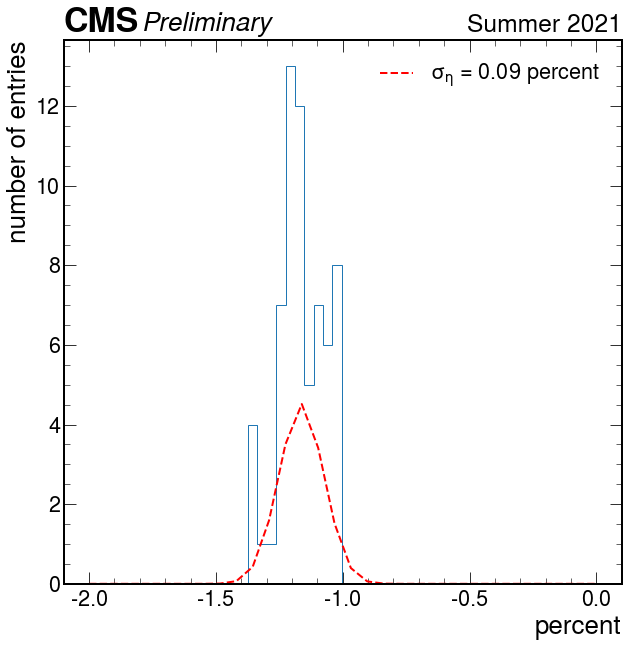

In [57]:
data = (analysis['s_ypp'].values/analysis['s_yll'].values)-1

#print(data)
bins = np.linspace(-2,0,32)
f, ax = plt.subplots()
plt.hist(data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu, sigma_y) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu, sigma_y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{\eta}$ = %2.2f percent'%sigma_y)
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent', ylabel='number of entries')

ax.legend()
#plt.savefig('Week4/fit_eta_ratio.png')

In [58]:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")
bg_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [59]:
#here is an example, If you look at the size for the pf_cand array (in MB):
#bg_muons =[]
#for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
#    bg_muons.append(batch )
#bg_muons=ak.concatenate(bg_muons)
#print('array size = '+str(bg_muons.nbytes/1e6))

In [60]:
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

In [61]:
bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>5000)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [62]:
#All for the background sample - (old version)

#-----Skip this cell !

N = len(bg_muons) # number of events
#define data array
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=[]
    data['mu2_'+k]=[]
for k in ['vz','xi']:
    data['pr1_'+k]=[]
    data['pr2_'+k]=[]
for k in ['pt2','t','z']:
    data['pr_vtx_'+k]=[]
# add event kinematics
data['mll']=[]
data['mpp']=[]
data['evt_t0']=[]
data['ypp']=[]
data['yll']=[]
#loop over all events
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=bg_protons[i]
    pr1_idx=-1; pr2_idx=-1
    for i_pr, ispu in enumerate(pr.genproton_ispu):
        #if ispu: continue
        if pr.genproton_pz[i_pr]>0: pr1_idx=i_pr
        else: pr2_idx=i_pr
    #skip events if signal protons are missing
    if pr1_idx<0 or pr2_idx<0: continue
    #store muons
    #print(1)
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['mu1_pt'].append(mu1.Pt())
    data['mu1_eta'].append(mu1.Eta())
    data['mu1_phi'].append(mu1.Phi())
    data['mu1_m'].append(mu1.M())
    data['mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['mu2_pt'].append(mu2.Pt())
    data['mu2_eta'].append(mu2.Eta())
    data['mu2_phi'].append(mu2.Phi())
    data['mu2_m'].append(mu2.M())
    data['mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['mll'].append((mu1+mu2).M())
    data['yll'].append((mu1+mu2).Eta())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['pr1_xi'].append(xi1)
    data['pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['pr2_xi'].append(xi2)
    data['pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    data['mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=bg_vertices[i]
    data['pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['pr_vtx_t'].append(vx.vtx4D_t[0])
    data['pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=bg_event_info[i]
    data['evt_t0'].append(ev.genvtx_t0)


100%|██████████| 15296/15296 [00:49<00:00, 309.28it/s]


In [85]:
#All for the background sample - new

# -----This is not perfect, but better ------

N = len(bg_muons) # number of events
#define data array
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=[]
    data['mu2_'+k]=[]
for k in ['vz','xi']:
    data['pr1_'+k]=[]
    data['pr2_'+k]=[]
for k in ['pt2','t','z']:
    data['pr_vtx_'+k]=[]
# add event kinematics
data['mll']=[]
data['mpp']=[]
data['evt_t0']=[]
data['ypp']=[]
data['yll']=[]
#loop over all events
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    #store muons:
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['mu1_pt'].append(mu1.Pt())
    data['mu1_eta'].append(mu1.Eta())
    data['mu1_phi'].append(mu1.Phi())
    data['mu1_m'].append(mu1.M())
    data['mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['mu2_pt'].append(mu2.Pt())
    data['mu2_eta'].append(mu2.Eta())
    data['mu2_phi'].append(mu2.Phi())
    data['mu2_m'].append(mu2.M())
    data['mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['mll'].append((mu1+mu2).M())
    data['yll'].append((mu1+mu2).Eta())
    
    # find 2 protons where mpp is closest to mll
    pr=bg_protons[i]
    b_pr1_idx=-1; b_pr2_idx=-1
    #calculate minimum distance per muon mass entrie
    min_diff = min(abs(((mu1+mu2).M() - 13000.*np.sqrt(pr.genproton_xi*pr.genproton_xi))))
    #print(min_diff)
    
    #pickup protons in same +-direction with appropriate momentum loss cut
    b_proton_pos_idx=np.where(ak.to_numpy(pr.genproton_pz>0 & (abs(13000*pr.genproton_xi) <= abs(min_diff - (mu1+mu2).M()) ) ))[0]
    b_proton_neg_idx=np.where(ak.to_numpy(pr.genproton_pz<0 & (abs(13000*pr.genproton_xi) <= abs(min_diff - (mu1+mu2).M() )) ))[0]
    #print(b_proton_pos_idx)
    #print(b_proton_neg_idx)
    
    #create list of all possible pair combinations betwen list 1 and list 2:
    b_proton_pairs_idx=np.array(np.meshgrid(b_proton_pos_idx,b_proton_neg_idx)).T.reshape(-1,2)
    #pick up 2 first pair from the limited indices    
    b_pr1_idx, b_pr2_idx  = b_proton_pairs_idx[0]
    #b_pr1_idx = b_proton_pos_idx[0]
    #b_pr2_idx = b_proton_neg_idx[0]
    print(b_pr1_idx)
    print(b_pr2_idx)
    #store data and calculate variables 
    xi1=pr.genproton_xi[b_pr1_idx]
    xi2=pr.genproton_xi[b_pr2_idx]
    #print(len(xi1))
    #print(len(xi2))
    data['pr1_xi'].append(xi1)
    data['pr1_vz'].append(pr.genproton_vz[b_pr1_idx])
    data['pr2_xi'].append(xi2)
    data['pr2_vz'].append(pr.genproton_vz[b_pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    data['mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=bg_vertices[i]
    data['pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['pr_vtx_t'].append(vx.vtx4D_t[0])
    data['pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=bg_event_info[i]
    data['evt_t0'].append(ev.genvtx_t0)


  0%|          | 40/15296 [00:00<01:24, 180.05it/s]

0
1
1
0
0
4
2
0
1
0
2
0
2
0
0
1
0
2
0
4
0
2
0
3
1
0
0
2
3
0
0
1
0
2
0
1
0
2
1
0
2

  1%|          | 80/15296 [00:00<01:21, 186.72it/s]


0
0
1
0
1
1
0
1
0
2
0
2
0
0
1
0
1
0
3
0
1
0
6
0
1
2
0
5
0
0
4
2
0
0
4
0
2
0
2
0
2
1
0
0
3
5

  1%|          | 125/15296 [00:00<01:13, 205.56it/s]


0
3
0
0
2
0
1
0
4
3
0
0
1
6
0
3
0
0
1
0
4
0
1
0
1
1
0
2
0
1
0
0
1
2
0
0
1
2
0
0
2
4
0
0
3
0
3
1
0


  1%|          | 167/15296 [00:00<01:17, 196.06it/s]

2
0
0
1
1
0
1
0
2
0
0
3
0
1
0
3
1
0
1
0
0
2
0
3
0
1
1
0
0
2
0
2
1
0
0
2
2
0
1
0


  1%|▏         | 210/15296 [00:01<01:23, 179.97it/s]

0
3
1
0
0
2
0
1
0
1
2
0
1
0
1
0
0
3
0
1
0
1
2
0
0
2
2
0
2
0
0
3
0
3
3
0
5
0
0
4
0
5
1
0
0
1
0
1
0
2
2
0
0

  2%|▏         | 272/15296 [00:01<01:28, 169.69it/s]


1
1
0
0
1
0
2
0
2
1
0
2
0
0
1
0
1
0
1
0
2
0
2
0
2
1
0
1
0
0
1
1
0
1
0
0
1
0
1
0
1
0
1
0
1


  2%|▏         | 311/15296 [00:01<01:24, 178.22it/s]

0
7
1
0
1
0
0
1
1
0
0
3
0
3
0
1
0
1
0
2
0
1
5
0
0
2
1
0
5
0
0
2
0
2
0
1
2
0
3
0
2
0
1
0
0
1
0
2
0
1
2
0


  3%|▎         | 383/15296 [00:01<01:13, 203.67it/s]

1
0
0
2
1
0
0
1
0
2
1
0
1
0
0
3
2
0
2
0
0
1
3
0
0
2
1
0
0
4
0
4
2
0
0
2
2
0
1
0
2
0
0
5
1
0
4
0
5
0
1
0
1
0
0
1


  3%|▎         | 436/15296 [00:02<01:08, 218.26it/s]

0
1
4
0
0
2
1
0
4
0
0
1
0
3
0
7
0
5
0
1
3
0
0
1
1
0
1
0
0
3
0
3
2
0
4
0
0
2
1
0
5
0
0
1
1
0
3
0
0
1
2
0
0
2
2
0
2
0
0
1
0
1


  3%|▎         | 511/15296 [00:02<01:04, 227.71it/s]

0
1
0
6
3
0
1
0
3
0
0
1
2
0
1
0
0
2
1
0
0
3
0
2
0
1
1
0
1
0
3
0
1
0
0
4
4
0
0
3
1
0
5
0
1
0
2
0
1
0
0
2
2
0
1
0
0
1
3
0


  4%|▎         | 558/15296 [00:02<01:10, 210.02it/s]

0
1
2
0
3
0
0
1
1
0
0
2
1
0
0
1
1
0
0
2
2
0
1
0
1
0
0
4
0
1
1
0
0
1
0
13
0
1
1
0
0
1
0
10
2
0
0
1
0

  4%|▍         | 631/15296 [00:03<01:05, 223.69it/s]


1
0
1
0
2
0
1
2
0
1
0
1
0
0
5
0
4
2
0
0
1
0
2
0
2
0
1
3
0
1
0
0
1
0
1
0
8
2
0
1
0
0
2
0
1
1
0
0
1
0
2
0
1
2
0
1
0
2
0
0
3


  5%|▍         | 703/15296 [00:03<01:11, 203.59it/s]

0
1
1
0
0
2
4
0
0
3
0
3
0
2
0
3
0
2
0
1
2
0
0
1
1
0
1
0
0
1
0
4
0
1
0
1
2
0
5
0
3
0
0
1
1
0
0
3
1
0
2
0
0
3
0
2
1
0
5
0
0
1
0
1
0
1
0
1
1
0
0
2
3
0
1
0
0
3


  5%|▌         | 767/15296 [00:03<01:15, 192.94it/s]

4
0
0
1
2
0
1
0
1
0
0
1
4
0
2
0
0
4
0
1
0
3
0
1
0
3
0
5
0
2
4
0
6
0
0
1
0
6
1
0
0
1
0
2
0
4
0
1
2
0
0
2


  5%|▌         | 834/15296 [00:04<01:14, 194.43it/s]

1
0
1
0
0
3
0
4
0
1
1
0
5
0
2
0
0
2
3
0
0
1
0
1
0
1
0
9
0
3
1
0
0
3
3
0
2
0
0
1
0
1
0
1
2
0
3
0
0
2
0
9
0
2
1
0
2
0
1
0
4
0
0
4
2
0
0
1
0
2
0
2


  6%|▌         | 906/15296 [00:04<01:06, 216.68it/s]

0
1
0
1
0
1
0
1
4
0
1
0
0
1
1
0
1
0
0
2
3
0
6
0
1
0
0
1
0
5
2
0
4
0
1
0
2
0
0
1
0
3
1
0
1
0
1
0
1
0
2
0
1
0
0
2
0
3
0
4
1
0
1
0


  6%|▌         | 949/15296 [00:04<01:13, 195.71it/s]

1
0
0
1
0
5
0
1
0
2
1
0
1
0
1
0
0
1
0
1
2
0
0
1
0
1
1
0
0
4
0
1
1
0
0
1
0
1
0
4
1
0
0
2
0
1
1
0


  7%|▋         | 1014/15296 [00:05<01:09, 205.64it/s]

0
1
1
0
2
0
1
0
2
0
3
0
1
0
0
1
0
1
2
0
0
2
0
1
0
4
1
0
0
1
2
0
0
3
0
2
1
0
0
3
6
0
1
0
0
1
0
2
0
1
0
1
4
0
0
1
1
0
0
1
0
2


  7%|▋         | 1064/15296 [00:05<01:05, 218.16it/s]

0
3
0
2
0
1
3
0
0
1
1
0
0
5
0
3
3
0
1
0
0
1
1
0
1
0
1
0
0
1
0
14
0
2
0
1
0
2
2
0
0
2
1
0
0
1
1
0
0
1
1
0


  7%|▋         | 1144/15296 [00:05<00:56, 249.47it/s]

0
1
2
0
1
0
3
0
1
0
2
0
0
3
2
0
0
1
0
1
0
2
0
2
1
0
3
0
0
1
1
0
0
1
0
1
4
0
1
0
0
1
1
0
0
2
0
1
1
0
2
0
0
2
0
2
1
0


  8%|▊         | 1222/15296 [00:05<01:03, 222.52it/s]

0
1
0
3
0
3
0
1
0
1
1
0
0
1
0
1
4
0
5
0
1
0
4
0
0
1
1
0
0
1
0
2
2
0
1
0
0
1
0
1
0
1
0
5
1
0
1
0
0
2
1
0
2
0
0
1
0
1


  9%|▊         | 1302/15296 [00:06<00:58, 240.43it/s]

0
1
4
0
0
3
0
1
1
0
2
0
0
1
0
3
0
1
2
0
0
1
0
1
2
0
2
0
1
0
5
0
0
1
0
1
1
0
1
0
0
2
0
1
2
0
0
4
0
1
0
2
0
2
1
0
1
0
1
0
1
0
0
1
1
0
2
0


  9%|▉         | 1360/15296 [00:06<00:57, 241.61it/s]

0
1
0
2
2
0
3
0
0
1
0
3
3
0
1
0
0
1
0
2
0
1
1
0
1
0
2
0
0
3
6
0
1
0
0
1
2
0
1
0
0
1
1
0
0
2


  9%|▉         | 1430/15296 [00:06<01:05, 212.70it/s]

0
2
0
4
0
2
0
1
0
2
1
0
2
0
2
0
0
2
0
1
1
0
0
2
1
0
0
1
1
0
0
1
1
0
1
0
0
1
0
4
0
5
0
1
1
0
0
2
5
0
2
0
0
2
2
0
2
0
1
0


 10%|▉         | 1472/15296 [00:07<01:15, 184.31it/s]

0
2
2
0
4
0
4
0
0
1
1
0
0
1
0
1
0
1
0
2
0
3
0
6
2
0
2
0
0
1
1
0
0
1
0
2
2
0
0
1
1
0
0
1
0
1
0
1
2
0


 10%|█         | 1546/15296 [00:07<01:03, 217.98it/s]

1
0
1
0
1
0
0
1
0
1
0
1
0
3
3
0
2
0
2
0
1
0
2
0
0
1
0
2
0
1
0
2
0
2
0
3
6
0
3
0
1
0
0
1
0
4
5
0
1
0
2
0
0
1
0
1


 11%|█         | 1646/15296 [00:07<01:03, 214.57it/s]

0
2
2
0
0
1
0
2
1
0
0
1
0
1
5
0
1
0
1
0
2
0
0
1
0
5
0
5
0
3
0
1
0
2
0
2
0
2
0
1
1
0
0
1
1
0
0
1
1
0
1
0
1
0
0
5
2
0
1
0
0
1
1
0
0
2
1
0
2
0
3
0
1
0
0
1
1
0
0
1
0
2
0
1
0
5
0
2
1
0
0
2
0
2
0
2
3
0
5
0
0
1


 12%|█▏        | 1767/15296 [00:08<00:58, 230.16it/s]

0
6
3
0
0
2
1
0
5
0
0
4
0
4
0
1
0
1
2
0
2
0
0
3
1
0
0
3
1
0
1
0
1
0
2
0
0
2
1
0
3
0
1
0
0
3
2
0
0
1
0
2
5
0
5
0
0
1
1
0
0
1
2
0
1
0
0
3
1
0
1
0
2
0
0
1
3
0
2
0
0
1
0
3
2
0
0
2
1
0
0
6
1
0
1
0


 12%|█▏        | 1838/15296 [00:08<01:03, 210.38it/s]

0
1
7
0
0
7
0
1
0
2
0
1
0
1
2
0
0
2
2
0
1
0
0
4
3
0
0
3
4
0
0
1
0
5
0
4
2
0
0
3
1
0
1
0
1
0
0
1
0
1
1
0
1
0
2
0
0
1
2
0
3
0
2
0
3
0
1
0
3
0
1
0
0
4
6
0
0
1
1
0
0
1
0
1
0
2
0
1
0
1


 12%|█▏        | 1902/15296 [00:09<01:08, 195.60it/s]

0
8
1
0
0
1
6
0
0
1
0
1
0
1
0
2
0
2
2
0
6
0
1
0
5
0
0
2
1
0
1
0
1
0
0
3
0
4
0
1
0
2
2
0
6
0
1
0
0
1
3
0
4
0


 13%|█▎        | 1958/15296 [00:09<00:56, 235.12it/s]

2
0
2
0
1
0
0
2
0
4
1
0
0
3
0
1
4
0
0
3
2
0
0
1
0
3
1
0
0
1
0
2
1
0
0
2
1
0
1
0
0
4
1
0
0
3
1
0
0
5
1
0
0
1
1
0
1
0
1
0
0


 14%|█▎        | 2102/15296 [00:09<00:49, 264.00it/s]

8
4
0
0
5
0
1
3
0
0
1
1
0
2
0
0
1
1
0
1
0
0
1
0
2
1
0
0
1
0
1
0
1
0
3
2
0
0
1
3
0
0
2
0
1
0
1
2
0
0
2
1
0
1
0
2
0
0
1
1
0
0
4
3
0
1
0
2
0
0
1
0
3
5
0
2
0
1
0
1
0
3
0
0
2
0
1
3
0
0
1
0
1
1
0
0
2


 14%|█▍        | 2211/15296 [00:10<00:53, 244.98it/s]

0
1
1
0
1
0
0
4
0
3
0
2
3
0
0
2
0
2
0
2
2
0
1
0
0
6
3
0
6
0
0
2
0
1
0
1
1
0
1
0
0
1
0
2
1
0
0
1
0
1
1
0
1
0
1
0
0
1
0
4
0
1
1
0
1
0
0
4
4
0
0
3
0
3
2
0
0
1
0
1
2
0
6
0
1
0
0
1
1
0
2
0
1
0
0
3


 15%|█▌        | 2321/15296 [00:10<00:50, 255.28it/s]

3
0
1
0
1
0
3
0
0
1
1
0
0
1
0
1
4
0
0
1
0
1
4
0
0
3
0
1
0
2
0
3
0
1
2
0
0
1
0
2
1
0
2
0
0
2
0
3
0
2
0
1
0
1
0
2
0
1
1
0
2
0
0
3
0
2
2
0
0
2
0
2
0
2
0
1
0
2
3
0
0
1
0
2
0
1
0
2
2
0
0
1
2
0
0
1
3
0
0
1
0
2
2
0
1
0
3

 16%|█▌        | 2422/15296 [00:11<00:50, 253.30it/s]


0
0
2
0
2
1
0
1
0
0
3
1
0
0
5
1
0
0
2
1
0
0
1
0
2
2
0
0
1
0
8
0
2
0
2
0
1
2
0
0
2
0
1
0
1
0
1
0
4
1
0
0
1
1
0
0
1
1
0
1
0
0
1
3
0
0
1
0
1
2
0
1
0
0
1
2
0
0
1
0
2
0
5
0
1


 16%|█▋        | 2500/15296 [00:11<00:56, 225.24it/s]

2
0
0
1
1
0
0
1
0
1
0
1
1
0
0
3
0
1
0
1
1
0
0
1
0
1
0
2
0
1
0
11
0
2
1
0
3
0
1
0
10
0
0
1
1
0
0
2
0
2
0
2
0
3
1
0
1
0
3
0
0
2
0
1
3
0
0
1
0
1


 17%|█▋        | 2605/15296 [00:11<00:57, 221.29it/s]

10
0
3
0
0
1
2
0
1
0
2
0
2
0
0
1
0
3
2
0
5
0
0
1
0
3
1
0
3
0
1
0
0
2
0
1
2
0
1
0
0
1
6
0
0
3
2
0
0
1
0
1
0
1
0
2
0
1
0
1
1
0
0
1
2
0
0
5
0
1
0
2
4
0
1
0
0
3
0
1
1
0
2
0


 17%|█▋        | 2675/15296 [00:12<00:59, 211.47it/s]

2
0
0
1
0
1
1
0
1
0
3
0
2
0
1
0
3
0
2
0
0
1
0
1
3
0
0
2
1
0
1
0
0
1
1
0
4
0
1
0
1
0
0
1
0
4
2
0
1
0
1
0
0
1
0
2
2
0
0
11
3
0
0
2
0
2
1
0
0
3
1
0
0
3
2
0
2
0
2
0
0
2
2
0
1
0
0
2
0

 18%|█▊        | 2810/15296 [00:12<00:48, 258.71it/s]


3
2
0
0
1
2
0
0
3
5
0
0
4
0
1
2
0
1
0
0
1
1
0
4
0
0
2
0
1
1
0
2
0
1
0
1
0
0
1
1
0
0
1
1
0
0
2
0
6
0
2
0
1
1
0
1
0
1
0
0
2
0
1
2
0
0
2
0
3
2
0
2
0
0
1
0
1
0
2
1
0
0
2
0
1
0
1
0
1
4
0
0
1
0
3
3
0


 19%|█▉        | 2888/15296 [00:13<00:57, 217.10it/s]

1
0
0
2
1
0
0
5
2
0
5
0
3
0
2
0
0
1
0
4
1
0
2
0
0
6
0
4
0
2
7
0
0
2
2
0
0
1
2
0
1
0
0
2
0
2
1
0
1
0
0
2
0
5
1
0
3
0
0
1
0
1
3
0
3
0
0
2


 19%|█▉        | 2963/15296 [00:13<00:53, 232.01it/s]

0
1
4
0
1
0
1
0
0
3
0
1
2
0
4
0
1
0
0
1
1
0
0
5
0
1
0
2
1
0
0
1
0
1
2
0
0
2
0
1
3
0
1
0
1
0
0
1
1
0
1
0
0
2
1
0
0
1
0
3
2
0
0
1
0
6
1
0
0
1
1
0
0
1
0
1
0
1
0
2


 20%|██        | 3089/15296 [00:14<00:49, 245.40it/s]

1
0
0
3
0
1
0
2
0
3
0
2
0
1
0
1
1
0
0
3
0
1
3
0
0
1
1
0
2
0
0
1
1
0
2
0
1
0
0
2
0
1
2
0
1
0
0
1
0
1
3
0
6
0
0
1
2
0
2
0
0
3
0
1
0
5
1
0
0
4
1
0
1
0
1
0
0
1
0
1
1
0
0
3
0
1
2
0
1
0
1
0
0
1
0
3
0
2


 21%|██        | 3194/15296 [00:14<00:48, 247.85it/s]

0
3
0
2
1
0
0
4
0
3
2
0
2
0
0
2
0
1
0
1
1
0
2
0
0
1
0
2
0
2
0
2
0
1
1
0
0
2
0
1
2
0
0
2
0
2
0
1
0
1
2
0
4
0
3
0
0
1
4
0
3
0
0
3
3
0
1
0
2
0
1
0
0
2
0
1
0
2
0
1
0
2
2
0
2
0
0
3
1
0
0
4
1
0
1
0


 22%|██▏       | 3351/15296 [00:15<00:49, 242.95it/s]

0
1
1
0
0
1
5
0
0
1
2
0
2
0
2
0
0
1
1
0
1
0
1
0
0
2
0
2
1
0
1
0
0
1
0
1
0
1
3
0
1
0
0
3
0
4
3
0
0
1
0
1
2
0
0
2
0
1
0
1
0
1
0
2
1
0
5
0
0
4
1
0
0
2
0
1
1
0
1
0
1
0
0
3
3
0
1
0
2
0
3
0
0
1
0
2
0
3
4
0
0
3
0
1
1
0
0
2
4
0
2
0
1
0
0
1
1
0
0
1
0
1
1
0
0
2
0
5
2
0
0
1
0
1
3
0
2
0
5
0
0
3
0
1
4
0
1
0


 23%|██▎       | 3448/15296 [00:15<00:39, 296.75it/s]

1
0
0
1
1
0
2
0
1
0
0
1
0
3
0
2
0
2
1
0
0
1
1
0
0
1
5
0
0
1
0
1
0
4
1
0
0
3
1
0
0
1
1
0
0
2
0
1
0
1
0
5
1
0
0
1
1
0
0
1
3
0
1
0
1
0
0
3
5
0
3
0
3
0
1
0


 23%|██▎       | 3536/15296 [00:15<00:45, 261.20it/s]

3
0
2
0
1
0
0
14
0
1
5
0
1
0
0
1
0
2
1
0
4
0
0
5
0
2
4
0
0
3
0
2
0
1
1
0
1
0
0
1
0
1
1
0
1
0
0
1
0
1
1
0
0
2
0
1
1
0
0
1
6
0
2
0
3
0
0
4
3
0
0
5
2
0
2
0
1
0
0
1
0
1
4
0
2
0

 24%|██▎       | 3599/15296 [00:16<00:47, 247.14it/s]


1
0
0
2
1
0
0
2
4
0
1
0
0
1
0
2
0
1
2
0
2
0
0
3
1
0
2
0
2
0
1
0
0
2
0
1
1
0
2
0
0
1
1
0
0
1
3
0
1
0
0
1
0
1
2
0
0
2


 24%|██▍       | 3676/15296 [00:16<01:01, 189.31it/s]

1
0
2
0
0
1
0
3
0
1
0
1
3
0
0
3
2
0
1
0
0
1
0
2
0
1
1
0
0
2
0
1
0
3
1
0
0
1
0
2
0
2
2
0
8
0
2
0
2
0
1
0
2
0
4
0
1
0
1
0
0
2
0
1
0
2
2
0
0
2
0
3
1
0
0
2
0
1


 25%|██▍       | 3781/15296 [00:17<00:58, 197.73it/s]

1
0
0
1
0
4
0
5
0
1
0
2
0
1
0
1
0
2
0
2
1
0
0
2
1
0
0
1
0
2
1
0
0
1
0
2
0
1
1
0
1
0
0
1
3
0
1
0
0
1
0
2
1
0
0
2
2
0
0
5
2
0
0
1
1
0
0
3
0
1
2
0
3
0
0
1
0
1
1
0
1
0
1
0
1
0
4
0
1
0
0
3
0
1
3
0
0
1
3
0
0
2
1
0
0
4
0
3
0
1
0
1
0
1
2
0
1
0
0
2


 26%|██▌       | 3905/15296 [00:17<00:42, 269.56it/s]

0
1
1
0
1
0
0
1
1
0
5
0
1
0
1
0
0
1
1
0
0
1
0
1
4
0
1
0
0
2
3
0
0
2
0
1
0
1
1
0
2
0
0
1
2
0
0
1
0
1
1
0
1
0
0
1
0
1
0
3
0
1
0
1
0
3
1
0
2
0
0
2
5
0
1
0


 26%|██▋       | 4048/15296 [00:18<00:44, 253.75it/s]

1
0
0
1
4
0
2
0
0
5
2
0
1
0
0
1
1
0
1
0
2
0
1
0
0
1
2
0
0
1
1
0
0
1
1
0
0
2
0
1
0
1
3
0
1
0
0
1
0
4
1
0
0
2
1
0
1
0
0
1
3
0
0
2
2
0
1
0
1
0
0
1
1
0
0
3
0
2
2
0
0
1
0
1
1
0
2
0
1
0
0
3
0
3
2
0
0
1
0
1
1
0
1
0
1
0
0
1
4
0
0
6
2
0
0
2


 27%|██▋       | 4148/15296 [00:18<00:48, 229.91it/s]

2
0
1
0
0
2
1
0
5
0
2
0
1
0
0
2
3
0
2
0
1
0
0
1
0
1
2
0
0
1
3
0
0
2
0
2
0
1
2
0
2
0
0
1
4
0
2
0
1
0
2
0
0
3
2
0
1
0
0
1
0
2
0
3
2
0
0
1
1
0
1
0
2
0
0
1
0
5
2
0
0
1
1
0
0
4
0
1
1
0
2
0
0
1
0
1
0
1
0
1
0
2
3
0
0
1


 28%|██▊       | 4321/15296 [00:19<00:58, 188.04it/s]

1
0
0
3
1
0
0
1
0
2
4
0
0
4
0
1
0
1
0
4
0
1
1
0
0
1
1
0
0
1
1
0
0
1
0
5
1
0
7
0
0
7
5
0
1
0
2
0
0
7
5
0
0
1
6
0
1
0
2
0
0
1
1
0
4
0
0
1
0
1
0
1
0
3
0
1
4
0
0
1
1
0
0
1
1
0
0
1
0
1
1
0
0
3
0
1
0
1
3
0
1
0
1
0
3
0
0
1
0
1
2
0
0
1
0
1
2
0
3
0
0
1
2
0
1
0
2
0
0
1
0
1
4
0
1
0
1
0
0
2
0
1
0
1
1

 29%|██▉       | 4426/15296 [00:20<00:45, 239.32it/s]


0
0
5
1
0
0
3
0
2
2
0
1
0
1
0
4
0
0
2
2
0
1
0
0
4
0
1
0
1
0
1
5
0
0
2
0
1
0
2
1
0
1
0
1
0
0
2
1
0
0
1
1
0
0
2
1
0
0
1
3
0
0
4
2
0
0
1
0
1
0
1
2
0
0
1
0
1
0
2
0
2
0
1
1
0
0
2
0
3
0
5
0
1


 29%|██▉       | 4508/15296 [00:20<00:42, 256.27it/s]

0
2
1
0
0
2
0
1
2
0
2
0
1
0
1
0
0
2
1
0
0
1
0
2
0
2
2
0
2
0
0
1
1
0
1
0
1
0
0
2
1
0
0
1
0
1
2
0
0
1
1
0
0
1
1
0
1
0
0
1
1
0
10
0
4
0
0
1
0
1
2
0
2
0
1
0
1
0
0

 30%|███       | 4596/15296 [00:20<00:40, 264.63it/s]


1
1
0
0
2
0
3
0
1
0
2
0
2
1
0
0
3
0
6
0
4
0
5
0
1
0
3
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
2
0
1


 31%|███       | 4697/15296 [00:21<00:47, 225.03it/s]

0
1
0
1
1
0
4
0
2
0
1
0
0
2
0
1
0
2
0
2
0
1
1
0
0
2
1
0
4
0
1
0
0
2
2
0
0
2
5
0
2
0
0
1
1
0
4
0
1
0
2
0
1
0
1
0
0
2
1
0
1
0
0
1
1
0
0
3
0
3
0
1
1
0
0
1
0
4
0
1
4
0
1
0
1
0
0
2
0
1
0
4
0
2
1
0
1
0
0
2
0
1
2
0
2
0
6

 31%|███▏      | 4793/15296 [00:21<00:49, 212.81it/s]


0
1
0
1
0
1
0
1
0
0
2
3
0
0
3
0
3
0
1
0
1
1
0
2
0
0
13
1
0
1
0
0
2
0
2
2
0
0
2
3
0
1
0
0
7
0
1
0
4
1
0
2
0
2
0
0
1
0
2
2
0
0
3
1
0
1
0
5
0
0
1
1
0
0
1
0
1
1
0
2
0
0
4
0
1
1

 32%|███▏      | 4906/15296 [00:22<00:43, 238.83it/s]


0
1
0
0
1
0
1
1
0
1
0
1
0
0
1
1
0
0
2
1
0
2
0
0
2
2
0
0
2
1
0
2
0
0
1
0
1
1
0
1
0
2
0
1
0
0
1
1
0
3
0
1
0
3
0
0
5
0
1
2
0
1
0
0
1
0
1
0
1
0
1
0
1
0
3
0
1
0
2
1
0
3
0
6
0
0
2
0
3
0
1
2
0
1
0


 33%|███▎      | 5009/15296 [00:22<00:43, 234.30it/s]

1
0
2
0
2
0
0
4
3
0
0
1
2
0
1
0
0
3
0
1
0
3
0
1
1
0
0
4
1
0
1
0
0
1
0
1
0
1
0
1
2
0
3
0
2
0
0
1
0
1
2
0
1
0
3
0
1
0
0
6
0
1
4
0
0
1
0
1
0
1
3
0
0
4
3
0
0
1
1
0
0
1
0
1
0
2
1
0
0
1
2
0
0
1
1
0
1
0
5
0
0
1
0
1
2
0
0
2
0
2


 33%|███▎      | 5082/15296 [00:22<00:48, 212.06it/s]

1
0
5
0
0
3
0
1
0
1
0
3
2
0
2
0
2
0
1
0
1
0
2
0
1
0
1
0
0
1
0
2
2
0
0
1
0
1
0
2
0
3
0
3
0
1
0
1
1
0
1
0
0
1
0
4
0
3
4
0


 34%|███▍      | 5187/15296 [00:23<00:43, 231.04it/s]

0
2
0
3
0
2
0
1
1
0
2
0
2
0
0
1
4
0
0
7
0
1
0
1
0
1
3
0
0
2
0
1
1
0
0
1
2
0
1
0
0
3
3
0
0
1
0
1
0
1
0
1
3
0
0
2
0
2
2
0
2
0
0
1
0
3
1
0
2
0
4
0
2
0
0
6
1
0
1
0
0
2
0
1
0
3
0
1
2
0
0
2
4
0
0
1
0
1
0
2
1
0
0
1
0
1


 35%|███▍      | 5317/15296 [00:23<00:40, 245.20it/s]

0
2
1
0
4
0
1
0
0
1
0
1
0
3
0
1
0
1
2
0
0
4
0
1
0
2
0
3
1
0
0
3
0
1
0
1
1
0
2
0
0
1
2
0
0
1
1
0
0
1
1
0
0
2
5
0
0
6
0
1
0
2
3
0
0
1
5
0
0
1
0
2
0
1
4
0
0
3
1
0
1
0
0
1
1
0
0
1
1
0
0
1
2
0
1
0
1
0
0
1
0
1
3
0
0
1
0
1
1
0
0
1
1
0
0
1
0
2
4
0


 35%|███▌      | 5395/15296 [00:24<00:48, 204.07it/s]

1
0
1
0
1
0
0
1
2
0
1
0
0
7
0
2
0
1
2
0
0
1
2
0
1
0
2
0
0
2
1
0
2
0
0
1
0
2
0
3
1
0
0
1
0
3
0
2
0
3
2
0
2
0
0
1
0
1
1
0
0
2
0
1
0
1
2
0
0
1


 36%|███▌      | 5512/15296 [00:24<00:42, 227.62it/s]

3
0
1
0
4
0
1
0
0
1
1
0
0
1
0
2
1
0
0
1
1
0
0
2
10
0
0
3
2
0
1
0
0
1
0
3
0
1
1
0
0
2
1
0
0
4
1
0
0
1
0
1
0
3
0
2
2
0
2
0
1
0
1
0
2
0
0
1
0
2
0
1
2
0
1
0
1
0
1
0
1
0
0
1
0
1
1
0
2
0
0

 37%|███▋      | 5584/15296 [00:25<00:45, 212.11it/s]


1
4
0
1
0
0
2
1
0
0
1
4
0
0
2
1
0
0
3
0
1
0
1
0
1
5
0
0
1
0
1
1
0
0
4
0
3
0
3
1
0
0
1
0
5
2
0
2
0
0
5
1
0
3
0
1
0
1
0
2
0
0
1
0
1
0
1
2
0
0
4

 37%|███▋      | 5708/15296 [00:25<00:39, 245.82it/s]


2
0
0
3
0
2
0
1
0
1
2
0
0
2
1
0
1
0
0
2
3
0
3
0
0
1
6
0
2
0
1
0
0
2
0
2
0
2
3
0
0
3
0
2
1
0
0
1
0
2
1
0
2
0
1
0
1
0
0
2
0
2
1
0
1
0
0
1
1
0
2
0
3
0
0
1
0
3
0
7
3
0
0
4
1
0
0
1
0
4
1
0
1
0
2
0
1
0
2
0
3
0
1
0
0
2
0
1
0
3
0
1
0
1
0

 38%|███▊      | 5821/15296 [00:26<00:39, 239.91it/s]


2
3
0
3
0
2
0
1
0
1
0
4
0
0
4
3
0
2
0
3
0
2
0
0
2
0
1
1
0
0
1
0
1
0
1
0
2
0
2
2
0
0
1
0
2
0
1
2
0
0
3
1
0
1
0
1
0
1
0
1
0
1
0
0
2
1
0
0
1
0
2
0
1
0
1
2
0
1
0
3
0
2
0
0
5
0
1
3
0
2
0
1
0
0
9
0
1
2
0
0
4
2
0
1
0
0
3
3
0
0
1


 39%|███▉      | 5933/15296 [00:26<00:51, 180.41it/s]

0
2
1
0
0
3
0
1
3
0
1
0
0
1
1
0
0
1
1
0
0
2
4
0
6
0
1
0
0
5
0
1
0
1
1
0
0
1
0
1
0
1
0
2
1
0
5
0
1
0
1
0
0
1
2
0
1
0
1
0
0
2
0
3
1
0
4
0
1
0
0
1
0
3
1
0
4
0
1
0
2
0
0
5
0
1
1
0
0
2
0
3
0
2
0
1
0
7
0
3
0
3
2
0
2
0
1
0
0
3


 39%|███▉      | 6019/15296 [00:27<00:50, 185.00it/s]

0
1
0
3
0
2
0
1
3
0
4
0
0
1
0
1
0
1
0
1
1
0
0
2
2
0
1
0
6
0
0
1
4
0
1
0
0
4
2
0
2
0
0
1
0
1
0
2
0
1
2
0
1
0
0
1
0
1
4
0
0
1
4
0
2
0
0
1
0
2
1
0
2
0
0
1
2
0
1
0
2
0
0
1
1
0
0
1
0
2
1
0
0
1


 40%|████      | 6146/15296 [00:27<00:39, 231.44it/s]

0
3
1
0
1
0
1
0
0
3
1
0
0
2
1
0
0
1
0
2
0
1
0
2
0
4
1
0
0
7
0
1
2
0
0
2
4
0
2
0
0
1
0
1
0
2
0
2
1
0
2
0
1
0
1
0
1
0
0
2
1
0
0
3
0
1
2
0
0
1
1
0
1
0
0
2
0
1
1
0
0
2
1
0
1
0
0
1
0
2
0
1
0
3
0
2
0
3
1
0
1
0
0
1
6
0
0
3
5
0
0

 41%|████      | 6265/15296 [00:28<00:43, 205.55it/s]


3
0
1
0
1
1
0
3
0
0
1
1
0
1
0
0
1
0
3
0
1
3
0
1
0
2
0
1
0
0
3
0
2
2
0
0
5
0
1
3
0
1
0
0
1
3
0
1
0
0
1
0
1
0
1
0
1
0
1
2
0
1
0
0
1
0
5
0
3
0
1
0
1
1
0
1
0
0
1
2
0
3
0
2
0
1
0
0
1
1
0
2
0
0
1
1

 42%|████▏     | 6354/15296 [00:28<00:44, 199.62it/s]


0
0
1
0
1
3
0
0
2
0
1
6
0
0
1
1
0
1
0
1
0
2
0
1
0
0
1
4
0
0
2
2
0
2
0
0
1
0
2
0
2
0
4
1
0
3
0
3
0
0
1
1
0
3
0
0
1
2
0
0
2
1
0
0
1
0
1
3
0
0
4
0
8
1
0
2
0
0
1
2
0
1
0
1
0
0
2
0
3
0
1
3
0
0

 42%|████▏     | 6453/15296 [00:29<00:44, 198.91it/s]


3
1
0
0
1
2
0
0
3
0
1
0
2
3
0
0
3
0
1
1
0
0
1
1
0
0
1
0
3
0
1
2
0
0
1
0
1
0
1
0
2
0
1
0
3
2
0
2
0
0
2
2
0
2
0
0
1
0
1
0
1
2
0
1
0
0
1
0
3
0
2
1
0
0
2
0
1
2
0
0
2
0
3


 43%|████▎     | 6569/15296 [00:29<00:42, 203.86it/s]

0
1
0
2
0
2
5
0
0
3
0
2
1
0
0
2
0
1
0
1
0
1
0
2
0
1
1
0
2
0
0
1
0
2
0
1
0
4
1
0
1
0
1
0
0
2
1
0
1
0
2
0
0
3
0
1
1
0
0
1
0
1
2
0
0
2
2
0
0
1
0
1
0
1
1
0
1
0
1
0
0
2
0
1
0
1
3
0
0
1
1
0
1
0
2
0
1
0
0


 44%|████▍     | 6702/15296 [00:30<00:39, 218.19it/s]

2
0
3
4
0
1
0
0
1
1
0
2
0
0
1
0
6
0
10
0
1
0
1
0
1
2
0
1
0
1
0
2
0
0
2
0
2
0
1
0
1
2
0
0
7
0
1
0
1
2
0
0
1
0
1
1
0
0
2
1
0
1
0
0
2
0
2
1
0
0
1
0
3
0
2
0
1
0
1
3
0
2
0
2
0
1
0
3
0
1
0
0
1
0
4
1
0
0
1
1
0
0
1
2
0
0
1
0
1
1
0
1
0
0
1
0
1
0
1
1
0
0
1
1

 44%|████▍     | 6806/15296 [00:31<00:39, 217.36it/s]


0
0
2
1
0
1
0
2
0
0
3
0
2
0
1
0
3
0
1
1
0
0
1
0
1
4
0
1
0
1
0
1
0
0
1
0
5
1
0
1
0
0
1
0
3
0
1
0
2
2
0
1
0
1
0
0
1
0
1
0
1
5
0
0
1
3
0
0
2
1
0
0
3
2
0
0
3
6
0
0
1
0
2
0
4
0
1
2
0
1
0
0

 45%|████▌     | 6911/15296 [00:31<00:42, 195.52it/s]


6
0
1
1
0
2
0
1
0
1
0
0
1
0
1
0
2
1
0
0
1
1
0
2
0
0
1
3
0
0
1
2
0
0
3
0
4
2
0
0
1
2
0
0
1
0
3
1
0
3
0
0
1
0
1
0
1
0
9
1
0
0
2
0
2
0
1
0
2
1
0
0
2
0
1
0
1
3
0
2
0
0
3
0
1
0
7


 46%|████▌     | 7013/15296 [00:32<00:39, 209.95it/s]

1
0
0
3
0
1
1
0
1
0
0
5
1
0
0
1
3
0
0
1
2
0
0
3
0
1
0
3
0
1
0
2
2
0
0
2
0
3
1
0
0
2
1
0
0
1
0
4
0
1
1
0
0
1
1
0
0
1
1
0
0
1
2
0
0
6
0
2
0
2
0
1
1
0
6
0
0
1
7
0
0
3
4
0
0
3
0
3
0
1
0
2
1
0
2
0
1
0
2

 46%|████▋     | 7083/15296 [00:32<00:39, 210.36it/s]


0
0
1
3
0
1
0
1
0
4
0
0
1
1
0
0
5
1
0
1
0
2
0
2
0
0
1
6
0
0
2
0
6
0
1
0
3
0
2
0
4
0
1
0
5
1
0
0
1
1
0
2
0
2
0
1

 47%|████▋     | 7234/15296 [00:33<00:37, 214.50it/s]


0
0
1
1
0
1
0
1
0
0
4
0
1
6
0
0
1
1
0
1
0
1
0
1
0
0
1
1
0
0
7
1
0
2
0
1
0
1
0
1
0
0
3
4
0
0
4
3
0
0
1
1
0
1
0
0
1
4
0
1
0
0
1
1
0
1
0
2
0
0
1
2
0
0
1
0
4
0
3
0
1
1
0
0
1
1
0
1
0
4
0
2
0
4
0
0
5
1
0
0
1
1
0
0
1
1
0
1
0
1
0
1
0
0
1
3
0
2
0
0
1
1
0
0
2
0
6
3
0
1
0
0
1
0
4
0
3
0
2
3
0
3
0
0
1
0
1


 48%|████▊     | 7367/15296 [00:33<00:34, 230.77it/s]

1
0
0
1
0
3
2
0
2
0
0
2
0
2
1
0
1
0
0
2
0
1
1
0
1
0
0
1
2
0
5
0
0
2
1
0
0
1
3
0
0
1
1
0
0
1
1
0
2
0
1
0
0
2
1
0
0
3
1
0
1
0
0
1
0
1
0
1
1
0
1
0
3
0
1
0
0
1
3
0
1
0
0
2
0
2
3
0
0
1
1
0
0
1
0
1
0
1
0
1
2
0
0
1
0
1


 50%|████▉     | 7574/15296 [00:34<00:32, 239.61it/s]

0
3
0
4
0
1
0
1
0
2
0
1
0
1
4
0
2
0
0
1
0
3
1
0
2
0
1
0
5
0
2
0
1
0
1
0
0
2
1
0
1
0
0
2
0
1
0
1
0
3
1
0
0
5
5
0
0
1
2
0
3
0
0
2
0
1
0
1
2
0
2
0
0
1
0
2
0
1
0
3
0
4
2
0
4
0
2
0
0
1
0
1
0
7
1
0
1
0
0
1
0
1
1
0
1
0
0
1
0
3
0
2
0
1
0
2
0
1
0
1
1
0
3
0
0
1
0
1
1
0
0
2
0
4
0
1
0
1
0
1
0
2
2
0
0
1
0
1
0
2
0
1
0
1
0
1
0
5
1
0
3
0
1
0
1
0
1
0
0
4
1
0
2
0
0
1
0
1
1
0
0
1
1
0
3
0
1
0


 51%|█████     | 7749/15296 [00:35<00:30, 246.03it/s]

0
2
0
1
1
0
3
0
0
3
0
5
1
0
0
1
0
3
0
1
0
1
1
0
0
4
1
0
2
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
2
0
0
1
0
3
2
0
0
1
1
0
0
3
2
0
0
4
0
2
0
2
0
1
0
2
0
8
0
1
2
0
1
0
0
1
0
1
0
3
0
4
0
3
0
1
2
0
0
2
1
0
2
0
0
2
0
1
0
1
0
1
1
0
0
1
0
1
1
0
1
0
1
0
1
0
0
2
0
3
0
1
3
0


 52%|█████▏    | 7895/15296 [00:36<00:47, 156.54it/s]

5
0
0
1
0
1
1
0
4
0
0
1
1
0
4
0
0
2
2
0
1
0
0
2
1
0
0
2
0
2
0
1
1
0
1
0
0
3
1
0
4
0
0
1
1
0
3
0
0
1
6
0
0
1
0
3
0
1
2
0
0
1
0
1
0
1
5
0
0
1
2
0
4
0
0
2
1
0
0
2
5
0
0
1
0
3
1
0
0
1
0
1
1
0
1
0
0
1
1
0
1
0
1
0
0
1
0
3
0
2
1
0
0
3
0
6
5
0
1
0
3
0
1
0
0
2
2
0
0
1
0
1
2
0
0
2
0
1


 53%|█████▎    | 8044/15296 [00:36<00:36, 198.47it/s]

0
1
2
0
0
2
0
1
0
2
1
0
0
1
0
1
0
1
0
1
0
2
0
1
0
4
4
0
0
1
0
1
0
2
1
0
0
2
3
0
0
2
1
0
3
0
1
0
0
1
3
0
2
0
0
2
1
0
1
0
0
1
2
0
0
1
0
1
0
1
0
1
0
2
1
0
0
2
2
0
0
1
3
0
1
0
2
0
0
2
2
0
2
0
0
1
0
1
0
2
4
0
1
0
2
0
0
1
0
1
0
1
0
7
2
0
1
0
0
1
0
1
1
0
0
2
1
0
1
0
1
0
0
2
0
3
1
0
2
0
1
0


 53%|█████▎    | 8111/15296 [00:37<00:35, 202.27it/s]

1
0
1
0
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
3
0
2
0
1
1
0
5
0
2
0
0
1
0
1
2
0
0
1
0
1
1
0
0
1
2
0
2
0
1
0
1
0
0
5
1
0
2
0
1
0
0
2
0
1
0
1
0


 54%|█████▍    | 8285/15296 [00:37<00:32, 213.96it/s]

4
0
2
0
1
1
0
1
0
0
3
4
0
0
1
3
0
0
2
2
0
2
0
0
1
0
2
1
0
2
0
3
0
3
0
0
1
2
0
0
1
0
1
0
1
1
0
5
0
0
1
1
0
3
0
0
1
3
0
2
0
0
1
1
0
1
0
1
0
2
0
1
0
1
0
2
0
0
1
0
1
0
1
0
1
0
2
3
0
1
0
3
0
1
0
1
0
1
0
0
2
0
2
0
7
2
0
0
1
0
2
0
3
0
1
0
4
1
0
0
3
2
0
0
1
0
1
0
1
0
2
3
0
0
1
0
2
0
1
0
1
0
3
0
1
1
0
0
2
6
0
0
1
1

 55%|█████▍    | 8379/15296 [00:38<00:34, 201.19it/s]


0
0
1
1
0
0
2
0
1
1
0
2
0
1
0
1
0
0
1
0
3
0
3
0
1
1
0
0
2
2
0
2
0
2
0
1
0
1
0
1
0
0
2
1
0
0
1
0
1
3
0
0
3
2
0
1
0
1
0
2
0
0
1
0
3
1
0
0
5
4
0
0
1
2
0
1
0
1
0
1
0
1
0
0
2
0
7
0
2
0
5


 56%|█████▌    | 8498/15296 [00:39<00:40, 166.97it/s]

0
1
0
1
0
2
3
0
2
0
0
1
0
2
2
0
1
0
1
0
0
2
0
1
0
4
2
0
0
1
2
0
0
1
0
1
2
0
0
1
0
1
0
1
2
0
0
2
0
2
3
0
0
2
1
0
0
2
1
0
1
0
0
2
0
1
0
1
1
0
0
1
0
1
0
3
0
5
0
1
2
0
0
2
0
2
3
0
0
2
1
0
1
0
0
4
2
0
1
0
0
1
1
0
0
2
1
0
0
1
5
0


 56%|█████▋    | 8624/15296 [00:39<00:32, 203.93it/s]

0
1
0
1
0
3
0
1
0
1
0
2
0
2
0
2
0
1
3
0
1
0
0
1
0
2
5
0
5
0
0
1
0
1
0
2
0
5
0
1
2
0
7
0
0
1
1
0
1
0
0
2
0
2
0
1
0
1
1
0
0
2
0
2
1
0
0
3
2
0
0
2
0
1
0
2
1
0
3
0
4
0
1
0
0
3
3
0
0
3
0
2
1
0
0
1
3
0
0


 57%|█████▋    | 8757/15296 [00:40<00:29, 221.59it/s]

1
0
2
0
1
0
1
0
1
1
0
0
1
0
1
1
0
2
0
3
0
2
0
0
1
0
1
0
1
0
1
2
0
2
0
2
0
1
0
0
1
0
1
3
0
0
1
7
0
0
2
0
4
4
0
5
0
0
1
1
0
0
2
1
0
0
2
0
1
0
1
1
0
1
0
2
0
3
0
0
3
1
0
0
1
1
0
0
1
1
0
1
0
0
3
0
3
0
1
0
1
2
0
2
0
0
2
0
1
2
0
0
1
0
1
4
0
1
0


 58%|█████▊    | 8884/15296 [00:40<00:32, 194.50it/s]

1
0
0
1
0
1
0
1
0
3
1
0
4
0
0
2
4
0
1
0
1
0
1
0
0
1
0
2
0
2
0
1
1
0
0
3
0
1
0
1
1
0
0
1
0
1
0
2
2
0
1
0
1
0
0
1
1
0
0
2
3
0
1
0
2
0
1
0
0
1
0
1
1
0
1
0
1
0
1
0
0
1
0
1
1
0
1
0
2
0
5
0
0
1
1
0
1
0
1
0
0
1
1
0
1
0
0
2
0
1
1
0
2
0
0
2
2
0
5
0
0
1
0
3
0
4
0
1
1
0
1
0
0
2
1

 59%|█████▉    | 9028/15296 [00:41<00:24, 252.03it/s]


0
0
1
1
0
3
0
1
0
0
3
0
1
2
0
1
0
0
2
0
1
0
1
2
0
1
0
0
1
1
0
2
0
0
1
0
2
2
0
1
0
0
3
0
4
0
4
1
0
4
0
0
2
2
0
1
0
2
0
3
0
0
1
0
1
5
0
0
1
0
1
0
2
1
0
0
4
0
2
0
3
0
1
0
3
0
3
0
1
2
0
0
1
1
0
0
1
4
0
1
0
0
1
3
0
0
1
4
0
0
1
0
2
0
6
0
4
2
0
0
1
0
1
0

 60%|█████▉    | 9138/15296 [00:41<00:25, 243.35it/s]


2
0
2
0
2
1
0
1
0
0
2
2
0
0
1
0
1
1
0
0
3
0
1
4
0
0
1
0
1
2
0
0
5
2
0
1
0
2
0
0
3
0
1
1
0
0
3
1
0
2
0
0
1
0
1
0
1
2
0
0
1
0
1
1
0
0
1
0
14
3
0
1
0
2
0
0
2
1
0
0
1
1


 61%|██████    | 9280/15296 [00:42<00:31, 188.77it/s]

0
1
0
2
0
0
3
0
1
0
1
0
2
0
1
0
1
0
1
2
0
0
1
0
1
0
3
0
1
0
1
2
0
0
2
0
2
1
0
1
0
1
0
0
1
1
0
1
0
1
0
4
0
2
0
0
1
0
1
0
1
8
0
0
4
3
0
2
0
1
0
2
0
0
2
0
1
1
0
1
0
1
0
1
0
0
1
0
2
2
0
0
3
2
0
1
0
0
7
1
0
1
0
1
0
1
0
4
0
0
1
1
0
0
2
0
1
2
0
0
2
1
0
2
0
4
0
0
1
2
0
1
0
0
3
0
2
2
0
0
1
2
0
1
0


 62%|██████▏   | 9448/15296 [00:43<00:25, 228.22it/s]

0
1
0
2
1
0
0
1
1
0
3
0
0
2
5
0
0
5
0
5
4
0
3
0
0
1
1
0
0
3
3
0
1
0
0
2
0
3
0
1
3
0
2
0
0
1
0
2
0
6
0
1
1
0
0
7
0
2
0
1
1
0
0
4
0
1
1
0
2
0
0
2
3
0
1
0
0
2
3
0
1
0
0
2
1
0
2
0
0
4
6
0
1
0
2
0
0
1
4
0
1
0
3
0
2
0
0
2
0
4
6
0
0
1
1
0
2
0
0
1
0
1
0
1
2
0
1
0
0
2
2
0
2
0
0
1
1
0
1
0


 63%|██████▎   | 9654/15296 [00:43<00:21, 263.80it/s]

0
1
0
1
1
0
0
1
1
0
0
1
2
0
1
0
0
1
1
0
0
1
0
2
0
1
0
1
0
1
5
0
1
0
1
0
0
4
2
0
4
0
1
0
0
1
1
0
3
0
0
1
0
2
4
0
1
0
1
0
2
0
0
1
1
0
0
1
1
0
0
2
1
0
5
0
2
0
0
1
2
0
0
1
0
2
0
3
0
1
6
0
0
2
0
4
2
0
2
0
0
2
1
0
0
2
0
2
0
1
0
2
0
1
2
0
0
5
0
4
0
1
1
0
0
1
2
0
0
1
0
2
0
2
1
0
1
0
1
0
0
1
0
4
0
1
0
2
1
0
0
4
4
0


 64%|██████▍   | 9782/15296 [00:44<00:19, 289.98it/s]

3
0
0
1
5
0
0
2
1
0
0
3
1
0
1
0
1
0
0
1
1
0
2
0
1
0
1
0
0
2
1
0
2
0
0
1
2
0
0
1
4
0
0
1
1
0
5
0
1
0
3
0
2
0
1
0
0
1
0
2
0
4
0
3
0
4
1
0
0
1
1
0
0
2
1
0
0
1
0
2
1
0
0
2
0
1
0
1
0
2
0
2
0
2
0
2
0
2
1
0
2
0
0
6
1
0
2
0
1
0
0
2
0
5


 65%|██████▍   | 9889/15296 [00:44<00:26, 207.68it/s]

0
1
0
1
3
0
0
2
0
4
0
6
3
0
0
2
1
0
5
0
0
5
1
0
0
1
2
0
1
0
1
0
2
0
0
1
0
1
0
2
2
0
0
1
1
0
1
0
0
1
3
0
0
1
0
3
2
0
1
0
2
0
2
0
3
0
0
4
0
1
3
0
0
1
0
4
1
0
0
1
0
1
0
1
0
2
0
4
0
1
0
1
1
0
0
3
0
1
1
0
0

 66%|██████▌   | 10058/15296 [00:45<00:22, 235.91it/s]


2
0
2
0
1
0
1
0
1
0
1
0
1
1
0
1
0
0
1
0
2
1
0
1
0
3
0
0
1
1
0
1
0
0
4
0
1
0
3
0
3
3
0
0
2
0
1
0
5
0
1
0
1
2
0
1
0
0
1
1
0
1
0
0
4
2
0
0
1
0
1
0
3
0
1
1
0
0
1
8
0
0
2
1
0
2
0
0
1
0
1
1
0
1
0
1
0
2
0
0
1
0
3
0
5
0
2
2
0
2
0
1
0
0
2
0
3
0
1
0
1
1
0
0
1
4
0
2
0
0
1
1
0
0
1
3
0
4
0
1
0
3
0
0
3
0
1
0
3
0
1
3
0
1
0
0
1
0
1
2
0


 66%|██████▋   | 10171/15296 [00:46<00:24, 208.31it/s]

5
0
1
0
2
0
0
1
1
0
0
4
1
0
0
1
1
0
2
0
0
2
0
1
0
2
2
0
0
2
0
3
3
0
0
1
0
2
1
0
0
1
0
3
1
0
1
0
0
1
2
0
0
2
0
2
1
0
1
0
1
0
0
3
0
7
1
0
0
2
1
0
1
0
0
3
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
2
0
1
1
0
1
0
1
0
3
0
0
1
0
1

 67%|██████▋   | 10273/15296 [00:46<00:23, 214.47it/s]


0
1
1
0
1
0
0
1
1
0
0
1
0
1
0
3
1
0
1
0
0
1
0
1
0
2
2
0
0
2
0
1
5
0
0
2
1
0
7
0
0
1
0
3
0
1
1
0
0
1
1
0
0
1
3
0
1
0
3
0
0
1
0
1
3
0
1
0
0
1
1
0
0
2
0
1
1
0
0
2


 68%|██████▊   | 10455/15296 [00:47<00:22, 215.64it/s]

0
2
1
0
0
3
0
1
0
2
1
0
3
0
0
2
1
0
0
1
1
0
1
0
0
1
2
0
0
2
5
0
0
1
1
0
2
0
1
0
0
2
0
3
0
4
3
0
0
1
0
2
0
1
0
1
0
1
0
2
0
1
0
1
0
2
0
3
0
1
1
0
0
4
0
2
0
1
1
0
1
0
0
2
0
1
4
0
1
0
0
2
0
5
0
1
1
0
2
0
1
0
0
1
1
0
1
0
1
0
2
0
1
0
0
1
2
0
1
0
0
2
3
0
1
0
0
1
0
1
0
2
2
0
0
1
2
0
5
0
0
2
0
1
0
6
0
1
0
1
0
1
0
5
0
1
1
0
2
0
0
1
1
0
2
0
4
0
0
3
1
0
0
1
2
0
0
4


 69%|██████▉   | 10554/15296 [00:48<00:21, 216.17it/s]

0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
0
1
3
0
3
0
0
1
0
3
2
0
0
2
1
0
1
0
0
2
2
0
1
0
0
1
1
0
0
1
0
1
2
0
0
2
1
0
0
4
0
1
0
2
2
0
0
7
0
1
1
0
0
1
2
0
3
0
1
0
2
0
1
0
2
0
2

 70%|██████▉   | 10707/15296 [00:48<00:19, 230.72it/s]


0
0
6
2
0
2
0
0
1
1
0
4
0
2
0
0
2
1
0
0
3
0
1
1
0
0
4
1
0
1
0
0
1
0
2
1
0
1
0
1
0
3
0
0
1
0
1
0
2
2
0
0
3
2
0
0
1
1
0
0
2
1
0
0
1
2
0
0
1
0
1
0
1
0
2
1
0
3
0
1
0
1
0
2
0
1
0
0
1
1
0
1
0
1
0
0
2
1
0
0
1
2
0
4
0
2
0
0
1
3
0
1
0

 72%|███████▏  | 10945/15296 [00:49<00:17, 246.75it/s]


2
0
3
0
0
5
0
2
2
0
3
0
0
1
1
0
0
1
1
0
1
0
2
0
0
2
0
3
3
0
0
2
0
4
1
0
1
0
0
1
0
1
4
0
4
0
0
2
4
0
2
0
0
1
0
1
0
1
0
5
2
0
0
2
0
1
2
0
1
0
0
1
5
0
3
0
0
2
1
0
2
0
4
0
0
1
0
1
1
0
0
3
2
0
2
0
1
0
0
1
3
0
0
3
0
3
0
2
0
2
0
3
2
0
0
2
0
2
0
2
2
0
0
2
0
1
0
2
0
1
1
0
4
0
0
1
0
3
0
1
2
0
0
2
1
0
2
0
1
0
1
0
0
1
1
0
2
0
0
2
1
0
0
1
1
0
0
3
2
0
0
2
0
3
0
7
1
0
1
0
2
0
2
0
0
3
0
2
0
5
0
1
1
0
0
2
0
2
2
0
1
0


 72%|███████▏  | 11053/15296 [00:50<00:18, 229.91it/s]

3
0
0
2
2
0
2
0
1
0
2
0
1
0
5
0
1
0
4
0
0
4
1
0
0
1
2
0
0
4
2
0
2
0
0
3
5
0
2
0
4
0
0
3
1
0
0
1
2
0
1
0
1
0
0
3
3
0
0
1
0
1
1
0
3
0
0
1
0
2
0
13
0
2
1
0
0
2
1
0
0
1
2
0
0
2
0
1
2
0
0
6
0
1
0
1
0
2
0
2
1
0
0
2
0
3
1
0


 73%|███████▎  | 11100/15296 [00:50<00:21, 195.20it/s]

0
1
1
0
5
0
1
0
1
0
1
0
2
0
0
1
0
2
0
1
0
1
0
1
1
0
0
1
1
0
0
2
1
0
0
3
0
5
0
3
4
0
0
4
0
3
0

 73%|███████▎  | 11175/15296 [00:51<00:27, 149.49it/s]


1
6
0
0
2
1
0
0
1
1
0
2
0
1
0
1
0
1
0
0
3
1
0
0
1
0
3
0
1
1
0
0
2
0
3
3
0
1
0
2
0
1
0
0
3
1
0
2
0
1
0
0
1
0
3
0
1


 73%|███████▎  | 11227/15296 [00:51<00:26, 152.14it/s]

1
0
0
1
0
1
2
0
10
0
1
0
0
4
0
1
0
2
0
3
2
0
0
1
0
3
0
1
1
0
0
1
1
0
0
1
2
0
4
0
1
0
0
8
0
4
2
0
0
2
5
0
0
1


 74%|███████▎  | 11268/15296 [00:51<00:23, 174.01it/s]

0
2
1
0
3
0
0
1
0
2
1
0
0
2
1
0
0
1
0
2
0
9
0
2
0
1
3
0
0
2
5
0
0
1
0
2


 74%|███████▍  | 11305/15296 [00:51<00:23, 168.12it/s]

2
0
0
1
0
4
0
1
1
0
0
2
3
0
1
0
0
1
3
0
0
1
4
0
1
0
4
0
1
0
1
0
1
0
2
0
0
2
0
2
1
0


 74%|███████▍  | 11349/15296 [00:52<00:21, 186.59it/s]

1
0
0
1
3
0
2
0
5
0
0
7
2
0
0
1
2
0
1
0
4
0
3
0
0
1
0
1
0
1
2
0
0
2
0
2
0
1


 74%|███████▍  | 11392/15296 [00:52<00:20, 192.88it/s]

1
0
0
2
0
3
0
1
0
1
0
1
4
0
1
0
5
0
1
0
2
0
0
3
0
1
0
6
1
0
2
0
0
1
1
0
0
1
1
0
0
2
0
1
0
1


 75%|███████▍  | 11439/15296 [00:52<00:18, 206.76it/s]

2
0
0
2
1
0
5
0
1
0
2
0
3
0
0
1
5
0
0
1
1
0
2
0
1
0
0
3
0
3
0
2
0
3
1
0
0
4


 75%|███████▌  | 11490/15296 [00:52<00:17, 223.39it/s]

0
1
0
2
1
0
0
4
2
0
1
0
2
0
1
0
0
2
0
1
2
0
1
0
3
0
5
0
1
0
1
0
0
3
12
0
0
5
3
0
2
0
1
0


 75%|███████▌  | 11535/15296 [00:52<00:18, 201.56it/s]

0
2
0
1
0
1
1
0
1
0
0
3
6
0
1
0
1
0
0
2
4
0
0
1
5
0
2
0
0
1
1
0
0
4
0
1
0
2


 76%|███████▌  | 11589/15296 [00:53<00:15, 232.22it/s]

1
0
3
0
1
0
1
0
2
0
3
0
1
0
2
0
0
1
0
1
1
0
2
0
0
2
0
1
1
0
0
1
0
1
1
0
0
1
0
2
1
0


 76%|███████▌  | 11637/15296 [00:53<00:17, 215.05it/s]

1
0
1
0
0
1
1
0
0
1
0
1
0
5
2
0
4
0
1
0
0
3
1
0
0
2
0
1
0
1
0
1
1
0
2
0
0
3
0
3
0
1
1
0


 77%|███████▋  | 11714/15296 [00:53<00:15, 228.87it/s]

1
0
0
1
1
0
0
1
0
2
0
2
0
3
0
1
1
0
1
0
1
0
0
2
0
1
0
2
1
0
1
0
8
0
0
1
3
0
3
0
1
0
2
0
1
0
5
0


 77%|███████▋  | 11766/15296 [00:54<00:16, 214.85it/s]

0
1
0
4
0
1
0
2
0
5
0
2
2
0
1
0
0
2
0
1
0
2
0
3
0
1
0
5
0
1
0
1
1
0
2
0
1
0
3
0
0
3
1
0
1
0


 77%|███████▋  | 11819/15296 [00:54<00:14, 233.37it/s]

1
0
4
0
3
0
1
0
0
1
2
0
2
0
0
1
0
2
5
0
0
2
0
1
0
1
3
0
0
4
0
1
0
2
0
1
2
0
0
1


 78%|███████▊  | 11873/15296 [00:54<00:14, 236.44it/s]

1
0
0
1
1
0
0
4
0
1
2
0
2
0
0
1
0
2
0
1
0
3
2
0
0
1
0
1
1
0
0
1
1
0
2
0
0
1
0
4
0
1
4
0
0
4
0
1
0
2
1

 78%|███████▊  | 11948/15296 [00:54<00:14, 224.75it/s]


0
0
1
0
2
1
0
0
2
4
0
0
2
0
1
1
0
1
0
0
2
0
3
3
0
0
3
1
0
1
0
2
0
0
1
0
1
0
2
1
0
2
0
0
2
0
2
0
1
1
0
2
0
1
0
3
0
1
0
2
0
0

 78%|███████▊  | 11992/15296 [00:55<00:16, 195.06it/s]


1
0
1
0
2
0
4
0
1
0
5
1
0
1
0
3
0
0
2
0
2
0
5
4
0
0
1
2
0
3
0
0
2
1
0
0
1
0
2
0
5
2
0
2
0
0
1


 79%|███████▉  | 12068/15296 [00:55<00:14, 222.82it/s]

1
0
0
2
1
0
0
1
0
2
0
2
3
0
2
0
0
1
4
0
2
0
0
2
0
5
5
0
0
1
0
2
0
1
0
1
1
0
0
3
0
1
2
0
1
0
1
0
1
0
1
0
2

 79%|███████▉  | 12138/15296 [00:55<00:15, 206.89it/s]


0
1
0
0
2
1
0
1
0
0
1
1
0
0
1
2
0
3
0
0
3
1
0
0
4
2
0
1
0
1
0
0
1
12
0
0
1
3
0
1
0
1
0
1
0
2
0
0
1
0
1
1
0
1
0
2
0
0
1
0
2


 80%|███████▉  | 12189/15296 [00:55<00:15, 199.91it/s]

1
0
0
4
1
0
0
3
1
0
0
3
1
0
0
1
0
1
0
1
2
0
0
2
1
0
2
0
0
2
1
0
0
2
1
0
2
0
0
1
1
0
0
1
0
1
2
0
1
0
2
0
0
1
2
0


 80%|███████▉  | 12235/15296 [00:56<00:14, 205.52it/s]

0
1
0
1
1
0
0
6
1
0
0
1
1
0
2
0
2
0
1
0
1
0
0
1
0
1
0
1
0
1
2
0
1
0
4
0
0
1
2
0
0
1
2
0
0
2
0
1
2
0
0
1
1
0
3
0
5
0
0
1


 80%|████████  | 12280/15296 [00:56<00:14, 202.89it/s]

0
1
0
2
0
1
0
2
3
0
4
0
0
1
0
2
1
0
0
1
2
0
0
3
3
0
0
1
1
0
0
3
0
7
3
0
0
1
0
2
4

 81%|████████  | 12324/15296 [00:56<00:16, 182.60it/s]


0
1
0
0
2
0
2
0
6
0
3
2
0
2
0
1
0
6
0
1
0
3
0
1
0
1
0
1
0
0
1
0
5
1
0
0
2
0
2
0
2
1
0
0
1
1
0


 81%|████████  | 12386/15296 [00:57<00:15, 193.20it/s]

0
1
0
1
2
0
1
0
2
0
1
0
1
0
3
0
1
0
1
0
3
0
3
0
1
0
0
4
1
0
0
1
2
0
1
0
0
1
5
0
2
0
0
2
0
2
2
0
2
0
2
0
0
2
3
0
0
2
1
0
2

 82%|████████▏ | 12470/15296 [00:57<00:12, 233.70it/s]


0
0
1
0
1
5
0
0
1
1
0
0
2
0
1
1
0
2
0
2
0
0
1
0
1
1
0
3
0
1
0
0
1
0
7
1
0
0
5
1
0
1
0
2
0
0
3
1
0
1
0
3
0
1
0
1
0
0
1
0
1
2

 82%|████████▏ | 12517/15296 [00:57<00:13, 208.39it/s]


0
0
1
2
0
0
3
0
2
1
0
3
0
2
0
2
0
0
1
0
3
2
0
0
2
1
0
0
5
0
1
1
0
0
3
3
0
0
2
1
0
0
2
0
1
0
2
0
1
0
1
2
0
1
0
0
2
2
0
0
5
3
0
0

 82%|████████▏ | 12584/15296 [00:57<00:13, 206.17it/s]


1
0
1
1
0
1
0
0
2
0
1
1
0
0
2
0
3
1
0
3
0
0
1
0
4
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
0
3
1
0
1
0
0
1
0
1
2
0
0
2
0
1
2
0
1
0


 83%|████████▎ | 12680/15296 [00:58<00:10, 239.93it/s]

1
0
2
0
3
0
2
0
1
0
0
5
2
0
0
2
0
2
0
1
2
0
4
0
0
1
2
0
0
1
0
1
1
0
0
3
0
2
1
0
0
1
2
0
1
0
1
0
2
0
0
1
0
3
0
4
1
0
1
0
0
1
1
0
1
0
1
0
2
0
1
0
1
0
2
0
1
0
1
0
2
0
1
0


 83%|████████▎ | 12751/15296 [00:58<00:12, 206.76it/s]

0
1
1
0
0
2
1
0
0
1
0
1
1
0
0
8
0
3
1
0
0
1
0
3
2
0
0
1
1
0
0
3
3
0
1
0
0
1
0
7
2
0
0
2
0
1
3
0
1
0
0
1
0
3
1
0
1
0
0
1
0
5
0
3
1
0
3
0
1
0
1
0


 84%|████████▍ | 12820/15296 [00:58<00:11, 215.06it/s]

2
0
2
0
0
2
0
2
1
0
0
2
1
0
0
1
0
1
2
0
0
1
0
1
2
0
0
1
0
1
4
0
0
8
1
0
3
0
0
2
1
0
0
3
1
0
1
0
2
0
0
2


 84%|████████▍ | 12891/15296 [00:59<00:11, 214.49it/s]

2
0
0
1
0
1
1
0
3
0
0
1
0
2
0
2
0
3
1
0
0
1
0
1
0
2
3
0
0
5
0
1
0
1
1
0
1
0
1
0
0
2
4
0
2
0
0
1
3
0
2
0
0
3
2
0
0
1
2
0
1
0
1
0
6
0
4
0
0
1
0
1
0
1
6
0


 85%|████████▍ | 13001/15296 [00:59<00:09, 250.19it/s]

1
0
0
2
1
0
3
0
1
0
0
3
0
2
0
4
1
0
1
0
0
3
1
0
3
0
1
0
0
1
2
0
2
0
0
1
2
0
0
1
0
2
0
1
2
0
0
7
0
1
0
5
1
0
1
0
2
0
0
1
0
1
0
1
0
1
1
0
1
0
2
0
1
0
0
1
0
1
0
1
0
3
0
3


 86%|████████▌ | 13100/15296 [01:00<00:07, 288.37it/s]

0
4
5
0
0
2
1
0
1
0
0
1
0
1
1
0
0
1
0
1
1
0
0
2
2
0
1
0
3
0
0
1
0
1
1
0
0
1
3
0
0
2
1
0
0
1
0
1
0
2
1
0
0
1
2
0
0
3
0
1
0
3
1
0
2
0
0
1
0
4
0
1
4
0
1
0
1
0
0
3


 86%|████████▌ | 13160/15296 [01:00<00:07, 281.80it/s]

1
0
1
0
2
0
2
0
0
5
1
0
0
1
0
1
5
0
1
0
0
2
1
0
2
0
2
0
1
0
4
0
0
1
3
0
1
0
3
0
0
1
0
2
5
0


 86%|████████▋ | 13216/15296 [01:00<00:09, 227.48it/s]

2
0
0
2
0
1
0
3
0
1
1
0
2
0
1
0
0
6
0
1
0
2
3
0
0
3
2
0
0
1


 87%|████████▋ | 13294/15296 [01:00<00:08, 232.80it/s]

1
0
2
0
0
1
0
2
0
2
0
1
1
0
0
3
1
0
0
2
3
0
2
0
0
2
2
0
0
2
1
0
1
0
1
0
0
1
3
0
0
3
0
1
1
0
0
2
2
0
0
2
1
0
0
3
2
0
0
1
1
0
1
0
0
2
0
2
4
0
1
0
0
1
1
0


 87%|████████▋ | 13374/15296 [01:01<00:09, 211.72it/s]

2
0
0
1
0
1
0
2
0
1
2
0
2
0
0
5
0
1
3
0
1
0
0
1
0
2
0
3
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
3
2
0
1
0
0
1
3
0
2
0
0
1
0
1
1
0
0
1
1
0
1
0
0
1
0
1
2
0
1
0


 88%|████████▊ | 13444/15296 [01:01<00:08, 206.34it/s]

1
0
1
0
0
4
1
0
0
2
0
2
0
1
0
1
2
0
0
1
0
2
0
1
1
0
1
0
0
1
0
1
0
3
1
0
0
2
3
0
0
4
0
1
1
0
0
1
1
0
2
0
2
0
0
1
3
0
0
1
1
0
2
0
4

 89%|████████▊ | 13542/15296 [01:02<00:08, 207.49it/s]


0
0
3
2
0
0
2
0
1
0
1
0
1
0
3
2
0
0
1
3
0
0
1
1
0
0
1
0
2
0
1
0
4
1
0
0
1
0
2
0
1
0
1
1
0
1
0
0
4
1
0
0
1
1
0
0
2
0
2
1
0
0
2
1
0
0
5
6
0
0
2
1
0
1
0
1
0


 89%|████████▉ | 13585/15296 [01:02<00:09, 190.11it/s]

0
2
1
0
1
0
1
0
1
0
2
0
3
0
0
3
1
0
3
0
1
0
1
0
0
3
1
0
0
1
2
0
0
1
2
0
1
0
3
0
3
0
0
1
0
1
0
3


 89%|████████▉ | 13623/15296 [01:02<00:10, 158.92it/s]

0
1
1
0
1
0
1
0
1
0
2
0
0
2
3
0
0
2
0
1
0
7
1
0
1
0
1
0
0
1
0
1
0
1
0
3
2
0
0

 89%|████████▉ | 13675/15296 [01:03<00:10, 150.27it/s]


2
0
1
0
1
0
1
0
2
0
3
0
1
0
2
0
3
0
2
0
7
0
2
3
0
0
2
2
0
0
1
0
1
5
0
1
0
0
2
3
0
0
2
0
1
1
0
4
0
5
0
0
1
4
0
1
0
1
0
3
0
2
0


 90%|████████▉ | 13743/15296 [01:03<00:10, 152.55it/s]

1
0
0
1
0
2
2
0
0
4
1
0
0
1
1
0
0
2
0
2
0
3
0
3
2
0
1
0
0
1
2
0
1
0
2
0
1
0
0
2
0
1
1
0
1
0
3
0
0
2
0
1
0
1
1
0
0
2
1
0
0

 90%|█████████ | 13826/15296 [01:03<00:07, 184.30it/s]


3
1
0
1
0
0
1
0
1
1
0
0
1
1
0
2
0
0
2
0
3
0
2
1
0
0
1
2
0
3
0
1
0
0
1
1
0
0
1
0
1
0
1
0
1
0
4
1
0
4
0
1
0
0
1
2
0
0
1
0
1
1
0
0
1
0
2
0
1
0
3


 91%|█████████ | 13865/15296 [01:04<00:07, 187.46it/s]

0
3
2
0
0
1
0
5
1
0
4
0
2
0
0
3
1
0
0
2
0
2
5
0
0
1
0
3
3
0
1
0
0
1
0
4
0
1
5
0
2
0
0
2


 91%|█████████▏| 13973/15296 [01:04<00:06, 197.27it/s]

0
2
1
0
1
0
1
0
0
1
2
0
4
0
1
0
0
1
5
0
0
1
1
0
0
2
0
1
0
1
1
0
0
3
1
0
0
1
1
0
2
0
3
0
3
0
0
1
0
2
0
2
1
0
0
1
0
1
0
1
0
1
5
0
0
1
0
1
0
2
2
0
1
0
1
0
0
1
1
0
2
0
1
0
0
5
2
0
2
0
3
0
7
0
8
0
0
2
4
0
2
0
0
1
0
1

 92%|█████████▏| 14067/15296 [01:05<00:05, 219.51it/s]


7
0
0
3
2
0
0
3
0
1
1
0
0
1
0
4
0
3
1
0
0
1
0
3
5
0
0
1
0
1
0
2
0
5
0
3
0
3
0
4
1
0
0
1
1
0
1
0
0
1
0
1
0
2
1
0
0
1
1
0
3
0
0
1
0
2
1
0
0
4
0
2
0
3
2
0
0
1
1
0
4
0
0
1
0
5
0
1
1
0
4
0
0
2


 93%|█████████▎| 14174/15296 [01:05<00:04, 237.49it/s]

0
1
2
0
1
0
0
1
3
0
0
5
2
0
0
2
0
1
0
1
0
3
1
0
0
1
0
2
1
0
0
1
0
2
0
2
3
0
0
2
0
1
2
0
2
0
1
0
2
0
1
0
0
2
0
1
0
1
1
0
2
0
1
0
2
0
0
1
1
0
0
1
3
0
0
1
0
1
1
0
3
0
0
4
0
4
1
0
2
0
0
2
0
2


 93%|█████████▎| 14248/15296 [01:05<00:04, 233.94it/s]

0
2
3
0
0
1
2
0
4
0
0
1
0
2
1
0
0
1
1
0
0
1
0
4
0
5
4
0
0
2
0
4
2
0
1
0
1
0
1
0
3
0
3
0
1
0
0
2
0
3
0
2
0
1
1
0
1
0
1
0
2
0
0
2


 94%|█████████▍| 14359/15296 [01:06<00:03, 256.62it/s]

1
0
0
1
0
2
0
1
1
0
0
1
0
2
0
3
0
1
1
0
2
0
0
2
0
2
1
0
1
0
3
0
1
0
0
1
0
3
1
0
1
0
0
1
3
0
4
0
2
0
3
0
2
0
1
0
3
0
3
0
2
0
1
0
0
2
0
4
0
2
0
1
1
0
0
1
0
1
3
0
0
2
1
0
0
1


 94%|█████████▍| 14450/15296 [01:06<00:03, 227.17it/s]

0
1
1
0
1
0
1
0
0
1
2
0
0
4
0
1
0
2
0
2
2
0
1
0
0
2
0
1
0
2
0
1
1
0
0
5
0
2
0
1
0
1
0
2
0
1
0
1
0
1
2
0
1
0
0
1
1
0
2
0
0
3
0
6
2
0
1
0
2
0
0
1
0
4
2
0
2
0
3
0
0
1
2
0


 95%|█████████▌| 14546/15296 [01:07<00:03, 202.66it/s]

2
0
0
2
0
1
5
0
1
0
1
0
0
5
0
2
1
0
3
0
0
3
0
1
0
1
1
0
1
0
2
0
1
0
0
2
1
0
1
0
1
0
0
1
0
4
4
0
0
3
0
2
0
3
1
0
0
3
0
1
3
0
5
0
1
0
0
2
2
0
1
0
0
1
3
0
1
0
0
1
0
1


 95%|█████████▌| 14604/15296 [01:07<00:04, 167.20it/s]

4
0
1
0
3
0
1
0
3
0
0
1
1
0
0
9
1
0
0
2
1
0
0
1
1
0
0
1
0
2
0
2
0
1
3
0
1
0
0
4
2
0
0
2
1
0
1
0
0
1
5
0
0
2
1
0


 96%|█████████▌| 14681/15296 [01:08<00:03, 166.86it/s]

1
0
0
1
0
5
0
3
1
0
0
1
0
3
1
0
1
0
0
1
0
1
3
0
1
0
0
4
1
0
1
0
1
0
1
0
0
2
0
3
3
0
0
1
0
2
0
3
1
0
0
3
0
1
0
2
0
3
1
0
0
3
0
1
2
0
0
1
0
2


 96%|█████████▋| 14744/15296 [01:08<00:03, 183.53it/s]

0
1
0
3
2
0
0
1
1
0
0
1
2
0
1
0
0
1
1
0
1
0
0
1
1
0
0
1
0
1
0
1
0
5
0
3
1
0
1
0
0
1
1
0
0
2
0
2
0
1
2
0
1
0
0
5
1

 97%|█████████▋| 14806/15296 [01:08<00:02, 182.66it/s]


0
0
1
1
0
1
0
2
0
2
0
2
0
0
2
0
1
2
0
1
0
0
1
0
2
0
1
0
2
1
0
1
0
0
2
2
0
3
0
0
1
3
0
0
2
0
1
0
1
8
0
0
1
1
0
6
0
5
0
0
3
3

 97%|█████████▋| 14872/15296 [01:09<00:02, 191.54it/s]


0
1
0
1
0
6
0
0
2
0
6
0
2
0
1
2
0
1
0
0
1
0
1
0
1
0
2
0
9
0
1
2
0
0
1
2
0
3
0
0
1
0
5
0
3
0
1
2
0
0
1
0
4
1
0
6
0
0
2
1
0
1
0
2
0
0
2
3
0
1

 98%|█████████▊| 14976/15296 [01:09<00:01, 173.31it/s]


0
1
0
3
0
1
0
0
1
1
0
1
0
1
0
0
1
0
1
1
0
0
2
0
1
0
3
0
1
0
2
3
0
7
0
0
1
0
2
3
0
2
0
2
0
2
0
0
3
0
2
2
0
1
0
0
1
0
1
0
1
0
1
5
0
0
1
0
3
0
1
0
1
1
0
1
0
2
0
0
1
0
1
0
1
1
0
2
0


 98%|█████████▊| 15016/15296 [01:09<00:01, 178.11it/s]

0
1
0
3
1
0
2
0
0
3
2
0
0
1
2
0
0
1
0
4
0
3
1
0
1
0
0
5
0
1
1
0
1
0


 98%|█████████▊| 15057/15296 [01:10<00:01, 177.66it/s]

0
1
0
2
0
1
1
0
0
1
7
0
1
0
2
0
0
1
1
0
1
0
1
0
1
0
0
1
0
1
0
1
1
0


 99%|█████████▊| 15095/15296 [01:10<00:01, 176.08it/s]

0
3
0
3
1
0
1
0
0
1
0
12
0
1
1
0
1
0
0
2
0
5
0
1
0
1
0
5
1
0
1
0


 99%|█████████▉| 15130/15296 [01:10<00:01, 163.40it/s]

4
0
2
0
0
2
0
1
1
0
0
5
0
1
4
0
3
0
0
3
0
7
1
0
0
2
1
0
1
0
0
4
0
2
0
2
0
1
1
0
0
1
1
0
1

 99%|█████████▉| 15170/15296 [01:10<00:00, 176.70it/s]


0
2
0
4
0
1
0
0
7
1
0
1
0
2
0
1
0
1
0
0
2
1
0
0
3
2
0
3
0
1
0
0
2
0
4
1
0
3
0
2
0
1
0


 99%|█████████▉| 15208/15296 [01:10<00:00, 168.90it/s]

2
0
0
2
0
1
4
0
0
1
2
0
0
5
1
0
1
0
2
0
1
0
0
2
0
1
1
0
3
0
0
2
0
6
2
0
0
2
4
0
0

100%|█████████▉| 15264/15296 [01:11<00:00, 167.20it/s]


1
1
0
0
1
2
0
0
8
0
2
2
0
0
1
0
1
0
2
2
0
1
0
0
1
0
3
1
0
2
0
2
0
2
0
0
1
0
2
5
0
0
5
1
0
0
5


100%|██████████| 15296/15296 [01:11<00:00, 213.88it/s]


4
0
1
0
1
0
0
1
1
0
0
1
3
0
4
0
0
6
0
1
1
0
0
1
2
0
0
1


In [86]:
bg_anal = pd.DataFrame(data=data)

15296


[Text(1, 14.0, 'Number of muons in event'), Text(34.5, 1, 'number of entries')]

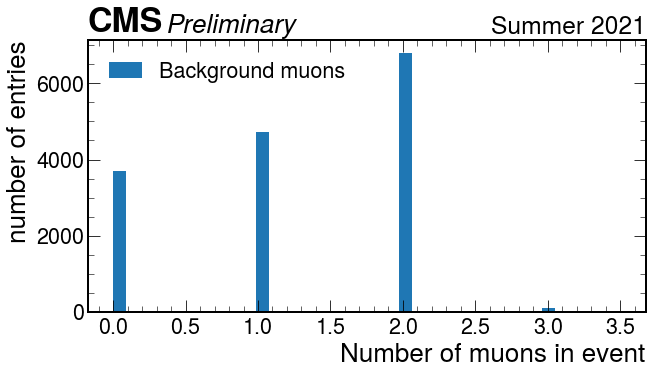

In [87]:


N = len(bg_muons)
print(N)
N_muons = []
for i in range(N):
    N_muons.append(len(bg_muons.pfcand_pt[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_muons, bins=np.linspace(0,3.5,40),label='Background muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('AnalyseW2/Bg_number_muons_signal.png',bbox_inches='tight')

0          7.898365
1        189.499649
2        239.842877
3       2258.512388
4       1686.589711
           ...     
6890       6.083098
6891    1510.167004
6892      23.448615
6893    2233.133229
6894     516.781356
Name: mpp, Length: 6895, dtype: float64


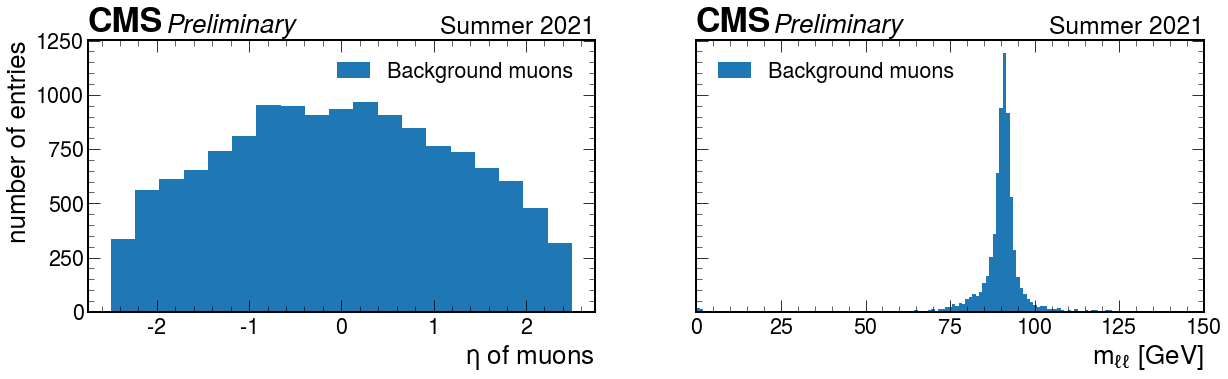

In [88]:
print(bg_anal['mpp'])
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].hist(np.concatenate([bg_anal['mu1_eta'].values,bg_anal['mu2_eta'].values]),bins=np.linspace(-2.5,2.5,20), label='Background muons')
ax[0].set(xlabel=r'$\eta$ of muons', ylabel='number of entries')
#ax[0].set_ylim(0,1200)

ax[1].hist(bg_anal['mll'].values, bins=np.linspace(0,150,150),label='Background muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')
ax[1].set_xlim(0,150)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
plt.savefig('AnalyseW2/bg_dimuon_analysis_corrected.png',bbox_inches='tight')

6895
64


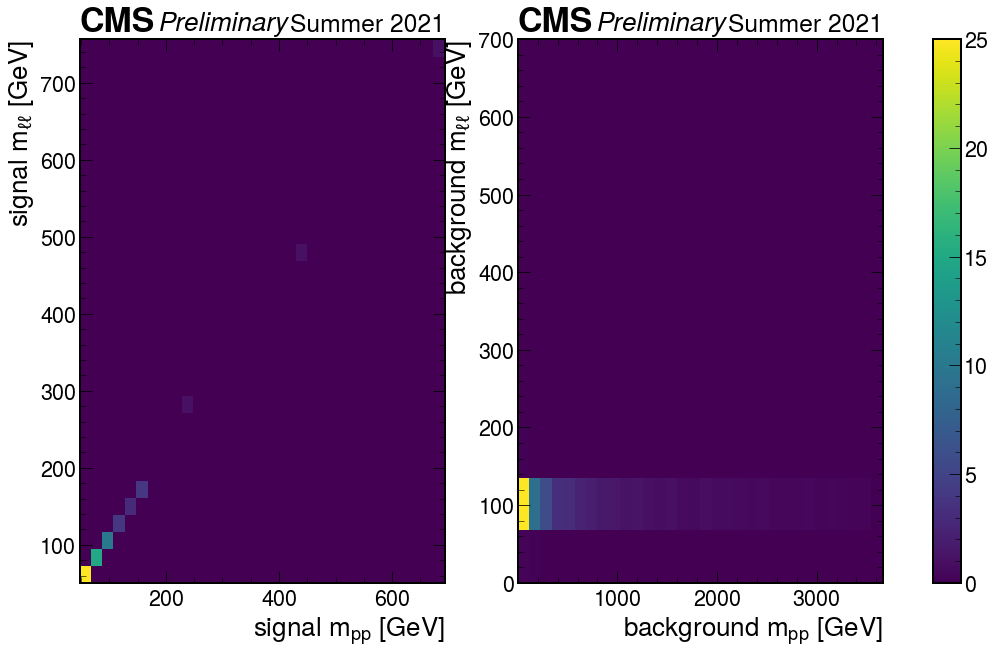

In [89]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))

h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(b_proton, b_muon, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
axes[1].set_ylim(0,700)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg')

6895
64
64


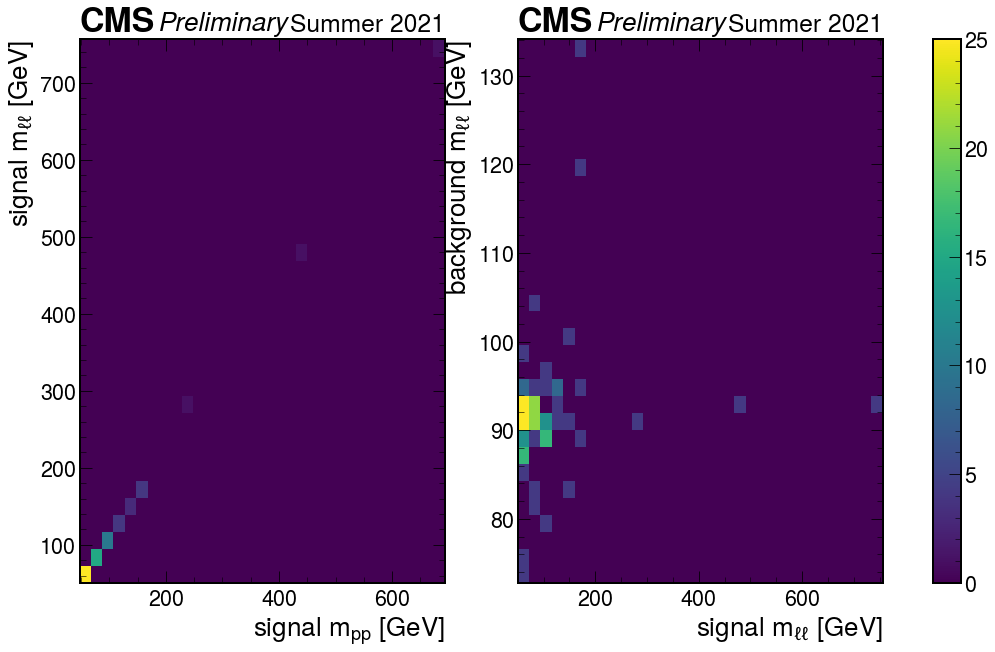

In [90]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))
m = []
for i in range(0,64):
    m = np.append(m,b_muon[i])
print(len(m))
h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(muon, m, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'signal $m_{\ell \ell}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg_corre')

In [96]:
#criteria for selection: |mpp-mll|<2sigma*mll
b = []
data = abs(bg_anal['mpp']-bg_anal['mll']) 

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*bg_anal['mll'][i]):
        b = np.append(b,bg_anal['mpp'][i])
#print(len(b))
m_acc_bg = len(b)/len(data)
print('acceptance rate from background mass:')
print(m_acc_bg)

s = []
data = abs(analysis['s_mpp'] - analysis['s_mll'])
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*analysis['s_mll'][i]):
        s = np.append(s, analysis['s_mll'])
#print(len(s))
m_acc_s = len(s)/len(data)
print('acceptance rate from signal mass:')
print(m_acc_s)

acceptance rate from background mass:
0.008992023205221175
acceptance rate from signal mass:
0.0


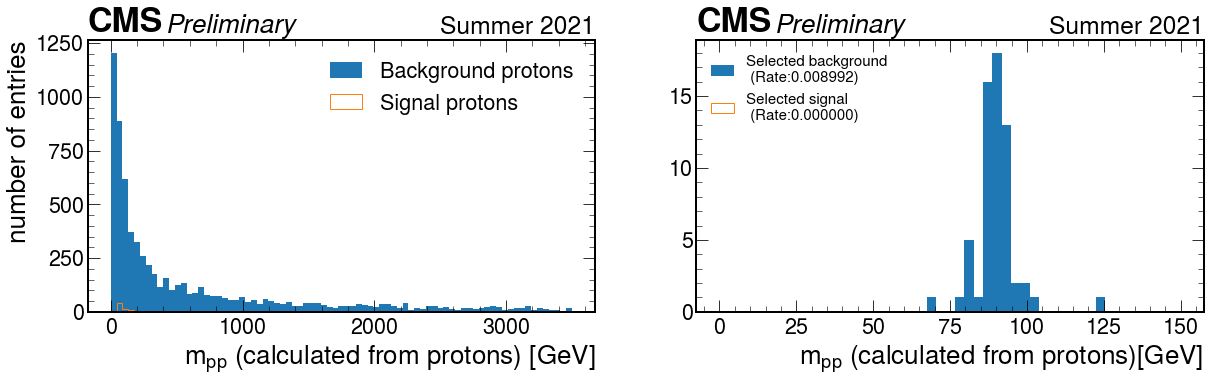

In [97]:

#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(0,3500,80)
ax[0].hist(bg_anal['mpp'],bins,label='Background protons')
ax[0].hist(analysis['s_mpp'],bins,histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]', ylabel='number of entries')
ax[0].legend()
bins = np.linspace(0,150,50)
ax[1].hist(b,bins,label='Selected background \n (Rate:%6.6f)'%m_acc_bg)
ax[1].hist(s,bins,histtype='step',label='Selected signal \n (Rate:%6.6f)'%m_acc_s)
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons)[GeV]')
ax[1].legend(fontsize=15)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    #ax[i].legend()
plt.savefig('Week4/surviving_protons_mass.png',bbox_inches='tight')

In [98]:
#criteria for selection: |ypp-yll|<2sigma*mll
b = []
data = abs(bg_anal['ypp']-bg_anal['yll']) 

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*bg_anal['yll'][i]) : #the abs has no impact for the background !
        b = np.append(b,bg_anal['ypp'][i])
#print(len(b))
y_acc_bg = len(b)/len(data)
print('acceptance rate from background eta:')
print(y_acc_bg)

s = []
data = analysis['s_ypp'] - analysis['s_yll']
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*analysis['s_yll'][i]): #but if I leave it out here, I have 0 for the signal acceptance!
        s = np.append(s, analysis['s_ypp'])
#print(len(s))
y_acc_s = len(s)/len(data)
print('acceptance rate from signal eta:')
print(y_acc_s)

acceptance rate from background eta:
0.04713560551124003
acceptance rate from signal eta:
28.0


6895
1792


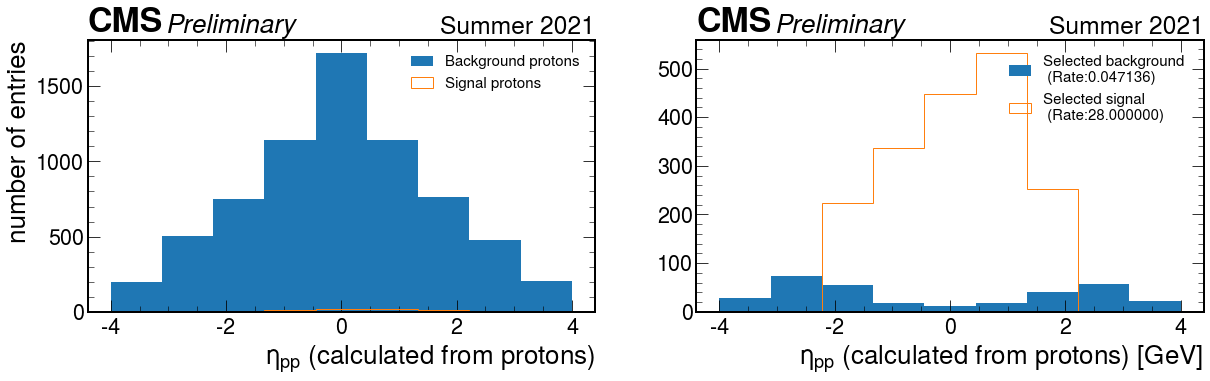

In [94]:

#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-4,4,10)
print(len(bg_anal['ypp']))
ax[0].hist(bg_anal['ypp'],bins,label='Background protons')
ax[0].hist(analysis['s_ypp'],bins, histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$\eta_{pp}$ (calculated from protons)', ylabel='number of entries')
binsb = np.linspace(-4,4,10)
print(len(s))
ax[1].hist(b,binsb,label='Selected background \n (Rate:%6.6f)'%y_acc_bg)
ax[1].hist(s,bins,histtype='step',label='Selected signal \n (Rate:%6.6f)'%y_acc_s)
ax[1].set(xlabel=r'$\eta_{pp}$ (calculated from protons) [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week4/surviving_protons_eta.png', bbox_inches='tight')

In [39]:
#________________________________________________________________________________________For the ultimate goal !
#def GetSignalProtons(all_proton_pairs):
#   DO SOME MAGIC
#and apply it on all proton pairs:
#proton_pos_idx=np.where(ak.to_numpy((pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0]
#proton_neg_idx=np.where(ak.to_numpy((pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0]
#create list of all possible pair combinations between list 1 and list 2:
#proton_pairs_idx=np.array(np.meshgrid(proton_pos_idx,proton_neg_idx)).T.reshape(-1,2)
#pick up signal protons:
#pr1_idx,pr2_idx = GetSignalProtons(proton_pairs_idx)